## Описание задачи

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень»


- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Описание данных
`market_file.csv`
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


`market_money.csv`
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.



`market_time.csv`
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.



`money.csv`
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

## Загрузка данных

In [1]:
!pip install shap -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import warnings


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance

In [3]:
#функция принимает в качестве обязательного аргумента столбец
#необязательные  аргументы xlim_hist, bins, xlim_box

#xlim_hist - список из двух элементов, мин и мах значения интервала, на котором будет построена гистограмма. 
#Пример: xlim_hist = [0,100]

#bins - число интервалов разбиения для гистограммы(корзин). Пример bins = 50 (значение по умолчанию)

#xlim_box интервал построения диаграммы размаха. Пример xlim_box = [100,1000] От 100 до 1000


def plot_hist_and_boxplot(feature, xlim_hist=0, bins=50, xlim_box=0):

    print("\033[4m"+ f'Основные числовые характеристики столбца {feature.name}:' + "\033[0m")

    print(feature.describe())
    
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.hist(x = feature, bins=bins, color='lightblue', edgecolor = 'black', )
    plt.grid()
    plt.title(f'Гистограмма частот для {feature.name}')
    plt.ylabel('частоты')
    plt.xlabel(feature.name)
    
    if xlim_hist != 0:
        plt.xlim(xlim_hist[0], xlim_hist[1])
    
    
    plt.subplot(1, 2, 2)
    plt.boxplot(feature, vert=False)
    plt.title(f'Диаграмма размаха для {feature.name}')
    plt.xlabel(feature.name)
    plt.grid()
    if xlim_box != 0:
        plt.xlim(xlim_box[0], xlim_box[1])
    plt.show()
    print('-'*110)
    print()

In [4]:
#своя функция для построения круговых диаграмм. Принимает датасет и необязательный аргумент -
#список его категориальных столбцов для построения. По умолчанию строит диаграммы для всех столбцов с типом данных object
def plot_pie(dataset, lst = []):
    
    #если не передали список интересующих столбцов
    if len(lst) == 0:
        lst = list(dataset.select_dtypes(include = 'object').columns)
        
    #если переданных столбцов несколько
    if len(lst) > 1:
        fig, ax = plt.subplots(1, len(lst), figsize = (20,5))
        count_axes = 0

        for categ in lst:
            val_counts = dataset[categ].value_counts()
            ax[count_axes].pie(val_counts, autopct = '%1.0f%%', colors=sns.color_palette('Set2'))
            ax[count_axes].set_title(categ)
            ax[count_axes].legend(labels = val_counts.index)

            count_axes += 1
    
    #если передали список только с одним столбцом
    elif len(lst) == 1:
        fig, ax = plt.subplots(figsize = (5,5))
        val_counts = dataset[str(lst[0])].value_counts()
        ax.pie(val_counts, autopct = '%1.0f%%', colors=sns.color_palette('Set2'))
        ax.set_title(str(lst[0]))
        ax.legend(labels = val_counts.index)

In [5]:
#функция для построения гистораммы в разрезе поцелевому признаку hue
def plot_hist(df, column, hue):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=hue, x=column)
    plot.set_title(f'Рапределение для {column}', fontsize=16)
    plot.set_ylabel('Кол-во наблюдений', fontsize=14)

In [6]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep = ';')

Посмотрим на первые строки датасетов

In [7]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [8]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [9]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


**Данные загрузились корректно, таблицы соответствуют описанию**

## Предобработка данных

###  Предобработка `market_file`

In [11]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [12]:
market_file.shape

(1300, 13)

1300 cтрок и 13 столбцов у датасета market_file

In [13]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Типы данных столбцов соответсвуют содержанию

**Приведем названия колонок к змеиному регистру**

In [14]:
market_file.columns = market_file.columns.str.lower()
market_file.columns = market_file.columns.str.replace(' ', '_')
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


посмотрим на пропуски в данных

In [15]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

**Пропусков в `market_file` нет. Проверим на наличие явных дупликатов**

In [16]:
market_file.duplicated().sum()

0

**Полностью повторяющихся строк тоже нет. Посмотрим на уникальные значения столбцов**

In [17]:
#функция печатает уникальные значения всех столбцов переданного ей датасета
def print_uniq_values(dataset):
    
    for col in dataset.columns:
        print(f'Уникальные значения столбца "{col}"')
        print(dataset[col].unique())
        print()
        print('\033[4m' + f'Количество уникальных значений {dataset[col].nunique()}' + '\033[0m')
        print()
        print('-'*50)
        
print_uniq_values(market_file)

Уникальные значения столбца "id"
[215348 215349 215350 ... 216645 216646 216647]

Количество уникальных значений 1300

--------------------------------------------------
Уникальные значения столбца "покупательская_активность"
['Снизилась' 'Прежний уровень']

Количество уникальных значений 2

--------------------------------------------------
Уникальные значения столбца "тип_сервиса"
['премиум' 'стандартт' 'стандарт']

Количество уникальных значений 3

--------------------------------------------------
Уникальные значения столбца "разрешить_сообщать"
['да' 'нет']

Количество уникальных значений 2

--------------------------------------------------
Уникальные значения столбца "маркет_актив_6_мес"
[3.4 4.4 4.9 3.2 5.1 3.3 4.7 4.2 3.9 4.6 4.3 3.8 2.7 4.8 2.9 3.  2.4 1.7
 3.6 4.  1.5 3.5 4.1 3.1 1.4 0.9 5.6 2.6 5.5 5.2 5.8 5.  5.4 5.7 5.3 3.7
 6.3 6.6 4.5 6.1 5.9]

Количество уникальных значений 41

--------------------------------------------------
Уникальные значения столбца "маркет_актив

**В столбце `тип_сервиса` присутствует неявный дупликат. Устраним его**

In [18]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [19]:
market_file['тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

In [20]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт','стандарт')
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [21]:
market_file['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

**Заметил грамматическую ошибку в столбце `популярная_категория`, лучше испавим**

In [22]:
market_file['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [23]:
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('аксесуары', 'аксесcуары')
market_file['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесcуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

**Также лучше будет привести все строковые значения к нижнему регистру значения**

In [24]:
for col in ['покупательская_активность', 'популярная_категория']:
    market_file[col] = market_file[col].str.lower()
    market_file[col] = market_file[col].str.replace(' ', '_')
 
#цикл для вывода уникальных значений по всем столбцам
print_uniq_values(market_file)

Уникальные значения столбца "id"
[215348 215349 215350 ... 216645 216646 216647]

Количество уникальных значений 1300

--------------------------------------------------
Уникальные значения столбца "покупательская_активность"
['снизилась' 'прежний_уровень']

Количество уникальных значений 2

--------------------------------------------------
Уникальные значения столбца "тип_сервиса"
['премиум' 'стандарт']

Количество уникальных значений 2

--------------------------------------------------
Уникальные значения столбца "разрешить_сообщать"
['да' 'нет']

Количество уникальных значений 2

--------------------------------------------------
Уникальные значения столбца "маркет_актив_6_мес"
[3.4 4.4 4.9 3.2 5.1 3.3 4.7 4.2 3.9 4.6 4.3 3.8 2.7 4.8 2.9 3.  2.4 1.7
 3.6 4.  1.5 3.5 4.1 3.1 1.4 0.9 5.6 2.6 5.5 5.2 5.8 5.  5.4 5.7 5.3 3.7
 6.3 6.6 4.5 6.1 5.9]

Количество уникальных значений 41

--------------------------------------------------
Уникальные значения столбца "маркет_актив_тек_мес"
[5

### Предобработка `market_money`

**Приведем названия колонок к змеиному регистру**

In [25]:
market_money.columns = market_money.columns.str.lower()
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [26]:
market_money.shape

(3900, 3)

Размер датасета 3900 cтрок и 3 столбца

In [27]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Типы данных столбцов соответсвуют содержанию

Посмотрим на пропуски в данных

In [28]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

Пропусков нет. Посмотрим на явные дупликаты

In [29]:
market_money.duplicated().sum()

0

Полностью повторяющихся строк нет. Посмотрим уникальные значения столбцов

In [30]:
print_uniq_values(market_money)

Уникальные значения столбца "id"
[215348 215349 215350 ... 216645 216646 216647]

Количество уникальных значений 1300

--------------------------------------------------
Уникальные значения столбца "период"
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Количество уникальных значений 3

--------------------------------------------------
Уникальные значения столбца "выручка"
[   0.  3293.1 4472.  ... 5224.6 4720.  4448.3]

Количество уникальных значений 2776

--------------------------------------------------


- странно значение ноль среди уникальных значений столбца `выручка`. В исследовательском анализе нужно будет рассмотреть


Заметим, что кол-во уникальных id в три раза меньше кол-ва строк в датасете (1300 и 3900 соответсвенно). Каждый уникальный id встречается ровно три раза. Здесь нет ошибки, поскольку для каждого id представлена информация за три месяца

In [31]:
market_money['id'].value_counts()

215349    3
215756    3
215792    3
215790    3
215788    3
         ..
216211    3
216209    3
216207    3
216205    3
216646    3
Name: id, Length: 1300, dtype: int64

In [32]:
market_money.duplicated(subset=['id', 'период']).sum()

0

Нет строк одновременно совпадающих по id  и периоду

### Предобработка `market_time`

In [33]:
market_time.columns = market_time.columns.str.lower()
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [34]:
market_time.shape

(2600, 3)

**Устраним опечатку**

In [35]:
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

Размер датасета 2600 строк на 3 столбца. Посмотрим на общую информацию

In [36]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Типы данных столбцов соответсвуют содержанию

In [37]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

Пропусков нет, посмотрим на дупликаты

In [38]:
market_time.duplicated().sum()

0

In [39]:
market_time.duplicated(subset=['id', 'период']).sum()

0

Полностью повторяющихся строк нет. Посмотрим на уникальные значения

In [40]:
print_uniq_values(market_time)

Уникальные значения столбца "id"
[215348 215349 215350 ... 216645 216646 216647]

Количество уникальных значений 1300

--------------------------------------------------
Уникальные значения столбца "период"
['текущий_месяц' 'предыдущий_месяц']

Количество уникальных значений 2

--------------------------------------------------
Уникальные значения столбца "минут"
[14 13 10 12  8 11  6  7  9  5 15  4 16 17 19 18 22 20 21 23]

Количество уникальных значений 20

--------------------------------------------------


Размер датасета 2600 строк, а  уникальных id в два раза меньше. Информация представлена по каждому id за два периода.

### Предобработка `money`

In [41]:
money.columns = money.columns.str.lower()
money.head()

,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


money.info()

**Из-за запятой тип данных столбца `прибыль` считался как строка. Приведем к числу с плавающей точкой**

In [42]:
money['прибыль'] = money['прибыль'].str.replace(',','.')
money['прибыль'] = money['прибыль'].astype('float')


In [43]:
money['прибыль'].dtype

dtype('float64')

Посмотрим на пропуски в данных

In [44]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

Пропусков нет. Посмотрим на дупликаты

In [45]:
money.duplicated().sum()

0

Полных дупликатов нет. Посморим на уникальные значения столбцов

In [46]:
print_uniq_values(money)

Уникальные значения столбца "id"
[215348 215349 215350 ... 216645 216646 216647]

Количество уникальных значений 1300

--------------------------------------------------
Уникальные значения столбца "прибыль"
[0.98 4.16 3.13 4.87 4.21 3.95 3.62 5.26 4.93 4.66 3.06 5.08 4.55 4.03
 3.49 1.83 2.67 3.65 2.95 3.03 6.27 3.86 2.82 1.4  1.63 3.69 4.08 4.18
 4.26 4.27 4.42 3.88 2.42 4.78 4.85 4.05 3.48 5.16 4.6  5.7  5.44 4.1
 2.93 3.9  3.28 5.09 3.19 4.77 5.01 6.73 7.43 4.28 3.73 3.38 3.47 5.
 2.02 3.68 2.68 4.46 2.41 5.4  3.4  4.22 4.5  4.98 3.96 3.18 4.65 3.92
 3.89 5.64 2.76 4.25 3.71 4.63 2.97 3.24 3.81 4.04 6.33 4.68 3.6  3.04
 4.41 3.98 2.47 4.52 4.01 5.31 2.53 5.83 4.48 2.98 4.92 3.08 4.9  3.94
 2.99 4.62 3.76 3.42 4.17 4.47 4.69 4.59 2.84 3.66 4.97 2.19 2.74 5.41
 4.12 3.93 5.02 3.52 3.39 6.12 4.64 3.14 4.71 4.99 3.74 4.   5.23 2.08
 6.55 2.36 4.32 3.15 2.77 5.56 3.44 3.58 2.92 4.67 3.33 2.94 1.06 2.45
 4.86 5.05 3.2  2.8  4.13 1.81 2.79 4.11 2.55 3.84 3.17 4.51 3.45 3.27
 4.2  4.33 3.0

Размер датасета совпадает с кол-вом уникальных `id`

**Вывод по разделу `Предобработка`**
- названия колонок всех трех датасетов были приведены к змеиному регистру
- пропусков и явных дупликатов в таблицах нет, типы данных столбцов соответствуют содержанию
- в `market_file был` устранен неявный дупликат `стандартт` - `стандарт`
- в `market_file` по столбцу `популярная_категория` была исправлена ошибка `аксесуары` - `аксесcуары`
- все строковые значения в `market_file` привел к змеионому регистру
- странно значение ноль среди уникальных значений столбца `выручка` датасета `market_money`. В исследовательском анализе нужно будет рассмотреть
- в `market_time` устранил опечатку `предыдцщий_месяц` -  `предыдущий_месяц`
- в `money` из-за запятой тип данных столбца `прибыль` считался как строка. Приведел к числу с плавающей точкой float


## Исследовательский анализ данных

### Исследовательский анализ `market_file`

In [47]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


Построим гистограммы по всем числовым столбцам

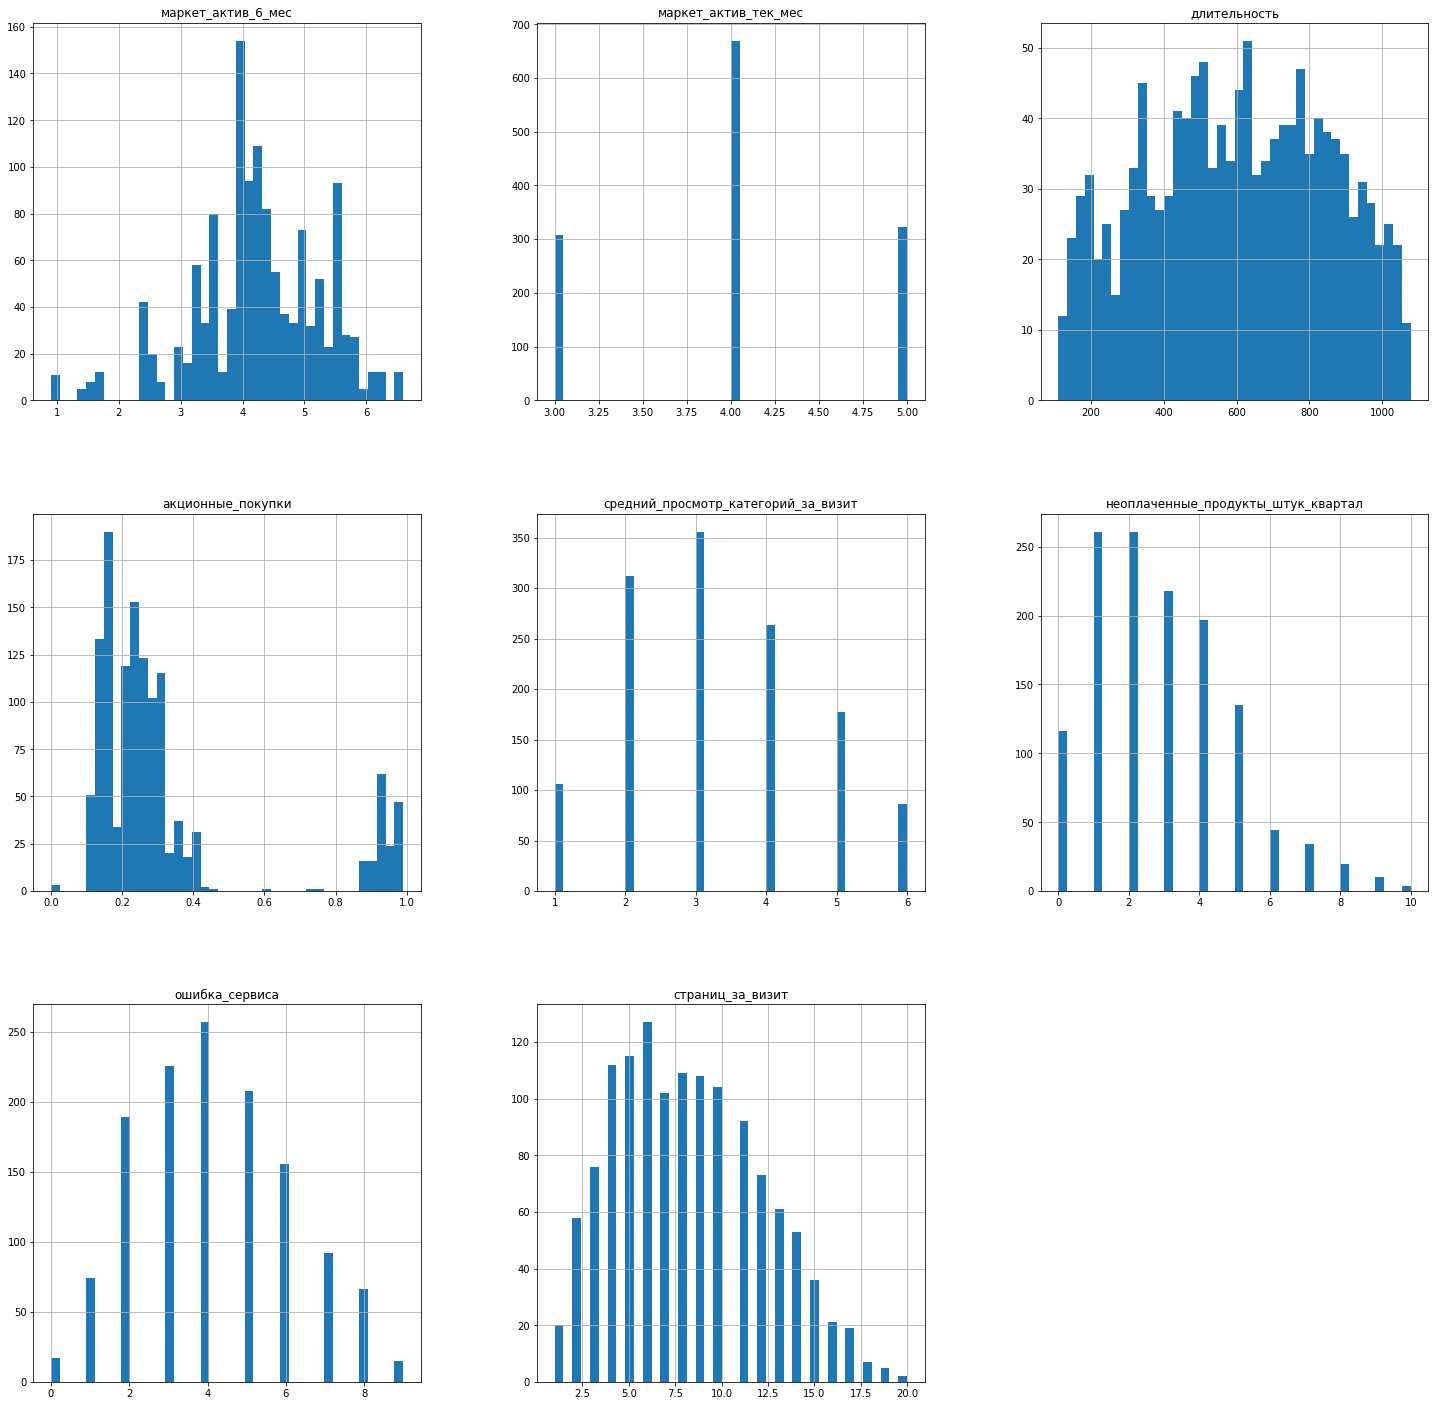

In [48]:

market_file.drop('id', axis = 1).hist(bins=40, figsize = (25,25))
plt.show()

- Некторые распредления имеют форму нормального или напоминают его. Например `ошибка_сервиса` и `страниц_за_визит` или `средний просмотр категорий за визит`. 


- Акционные покупки разделяются на 2 группы. Тех, у кого среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев не превосходила 0.5, и тех, кого эта доля была выше 0.8. 


- `длительность` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, имеет самое равномерное распределение из всех, но тем не менее у графика есть эксремум

**Рассмотрим подробнее графики каждого числового столбца**

Основные числовые характеристики столбца маркет_актив_6_мес:
count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


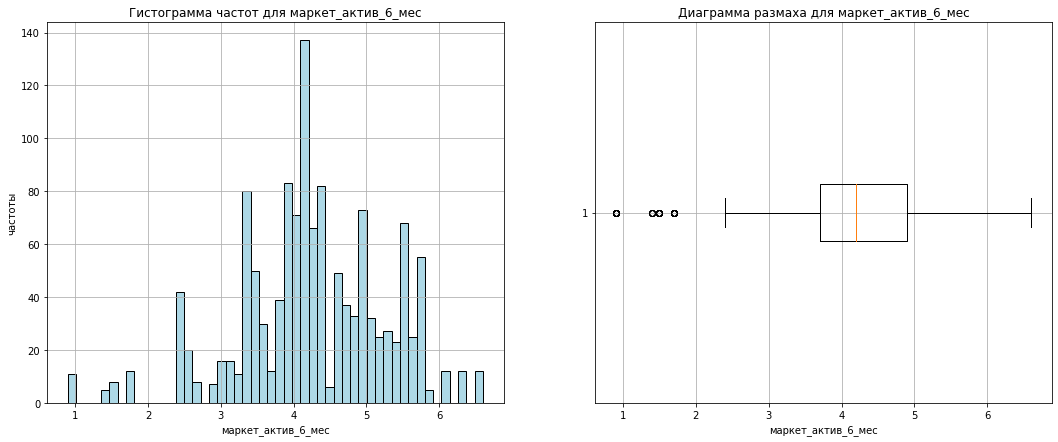

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца маркет_актив_тек_мес:
count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


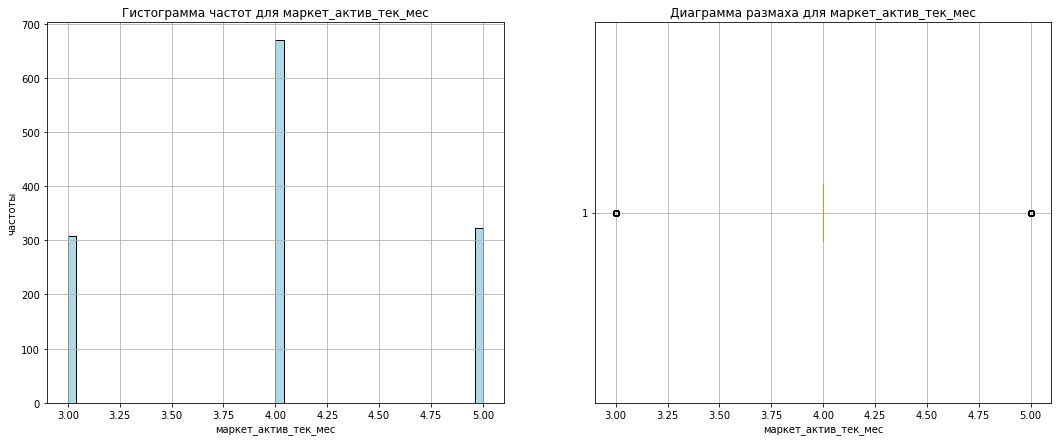

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца длительность:
count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


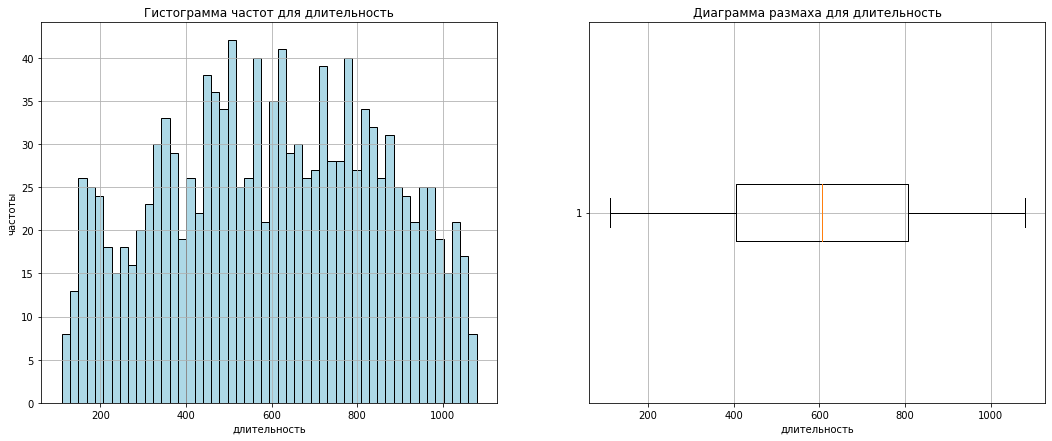

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца акционные_покупки:
count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


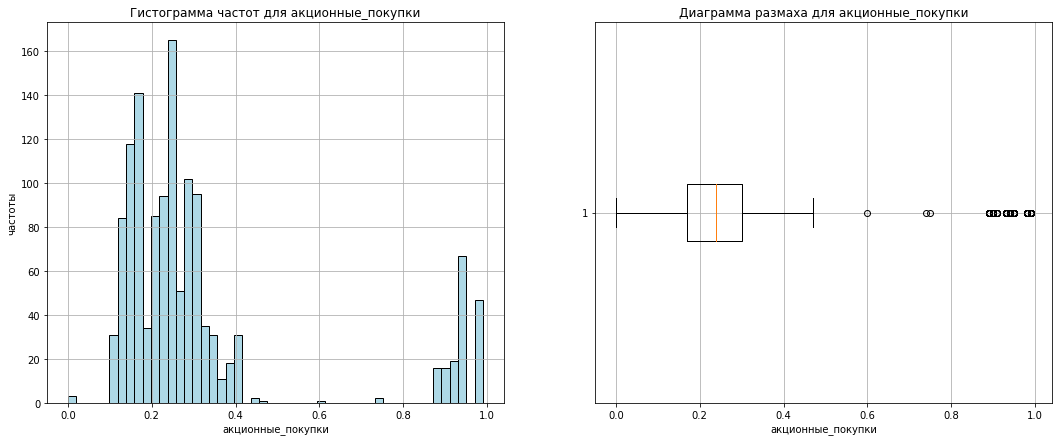

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца средний_просмотр_категорий_за_визит:
count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


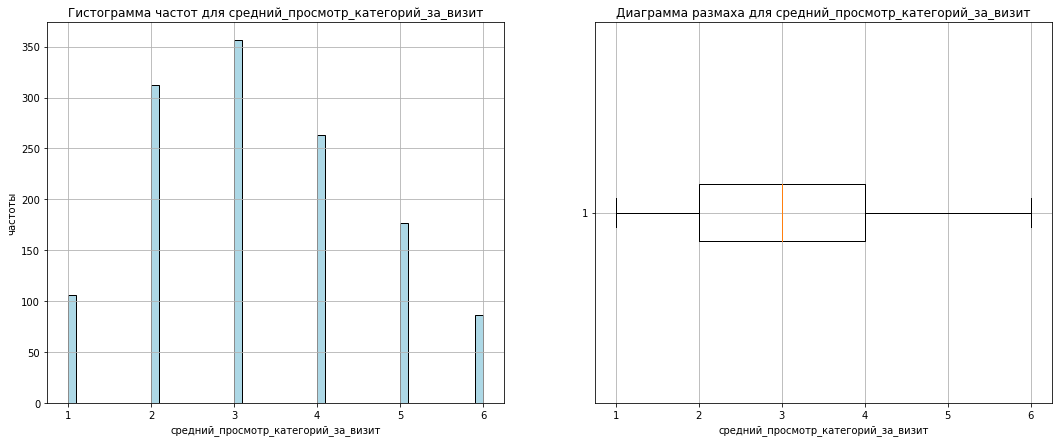

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца неоплаченные_продукты_штук_квартал:
count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


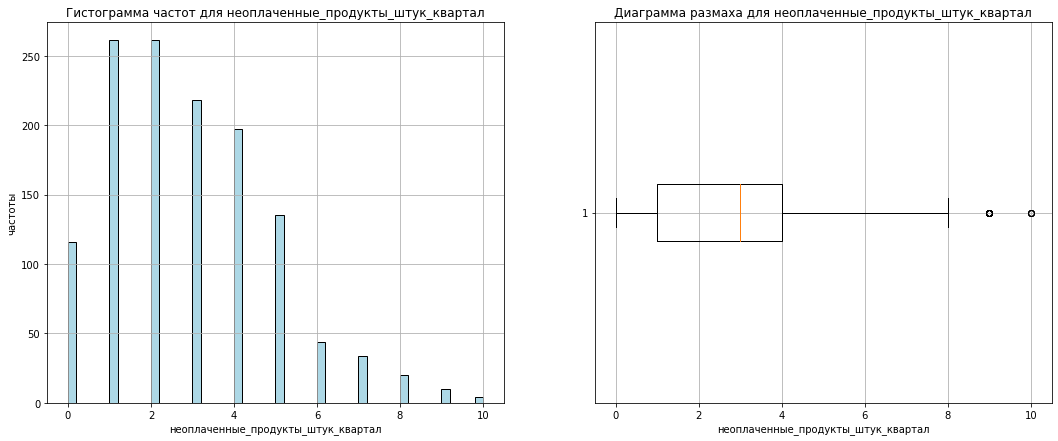

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца ошибка_сервиса:
count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


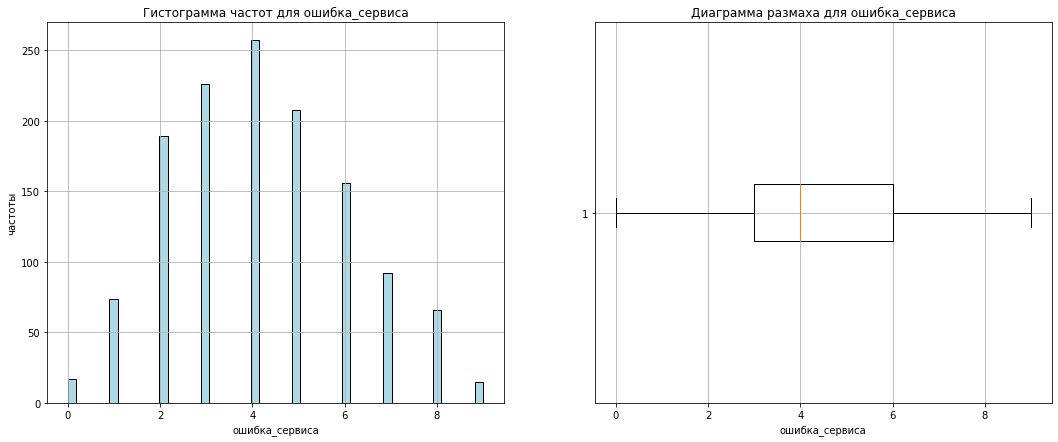

--------------------------------------------------------------------------------------------------------------

Основные числовые характеристики столбца страниц_за_визит:
count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


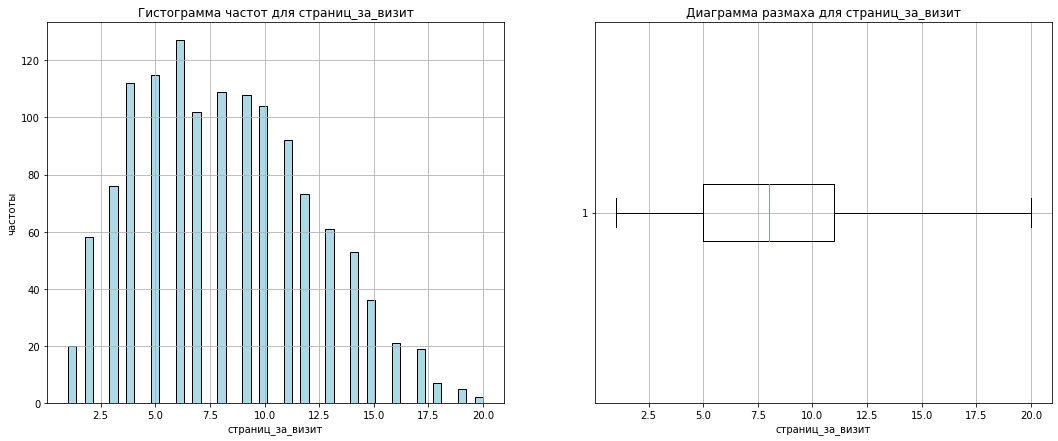

--------------------------------------------------------------------------------------------------------------



In [49]:
for col in list(market_file.drop('id', axis =1).select_dtypes(exclude = 'object').columns):
    plot_hist_and_boxplot(market_file[col])

**Нашлось несколько выбросов за пределами усов диаграммы размаха по столбцу `маркет_актив_6_мес`**

Основные числовые характеристики столбца маркет_актив_6_мес:
count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


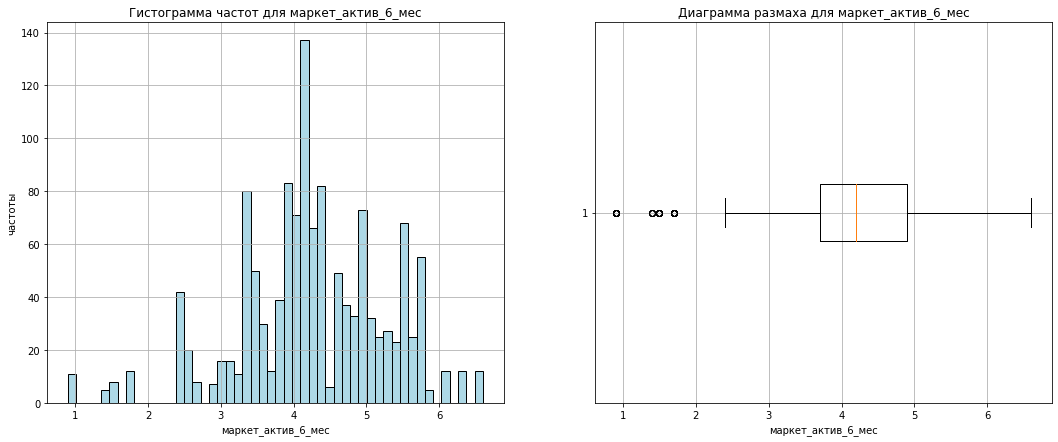

--------------------------------------------------------------------------------------------------------------

Количество выбросов 36


In [50]:
plot_hist_and_boxplot(market_file['маркет_актив_6_мес'])
print(f'Количество выбросов {market_file.query("маркет_актив_6_мес < 2")["id"].count()}')

In [51]:
market_file.query("маркет_актив_6_мес < 2")['маркет_актив_6_мес'].value_counts()

1.7    12
0.9    11
1.5     8
1.4     5
Name: маркет_актив_6_мес, dtype: int64

**Хотя выбросов не так много, я не могу их удалить, поскольку они носят не "размытый" характер, а собираются в 4 группы, выведенные выше через value_counts(). Это указывает на какую-то закономерность, которую не хочется терять**

Основные числовые характеристики столбца акционные_покупки:
count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


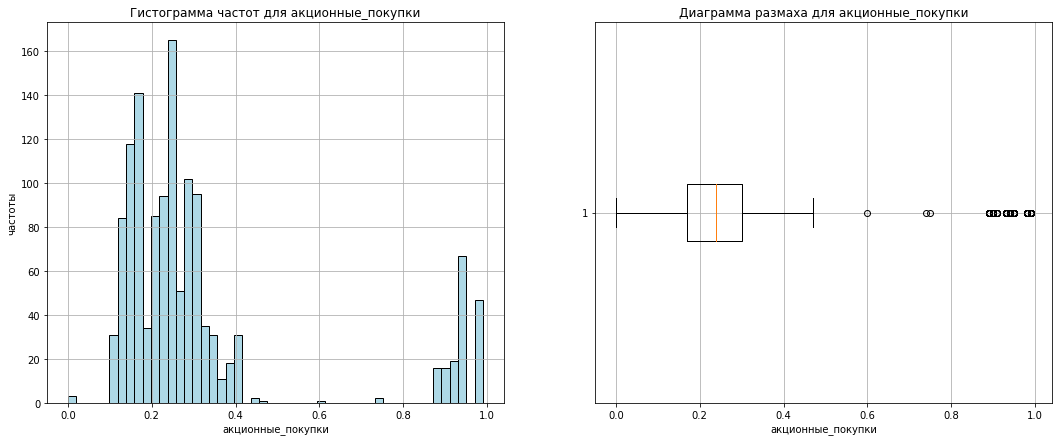

--------------------------------------------------------------------------------------------------------------

Количество выбросов 168


In [52]:
plot_hist_and_boxplot(market_file['акционные_покупки'])
print(f'Количество выбросов {market_file.query("акционные_покупки > 0.5")["id"].count()}')

**Эти выбросы удалять не буду, поскольку они судя по гистограмме образуют свою небольшую группу людей, часто предпочитающих акционные покупки**

Рассмотрим `неоплаченные_продукты_штук_квартал`

Основные числовые характеристики столбца неоплаченные_продукты_штук_квартал:
count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


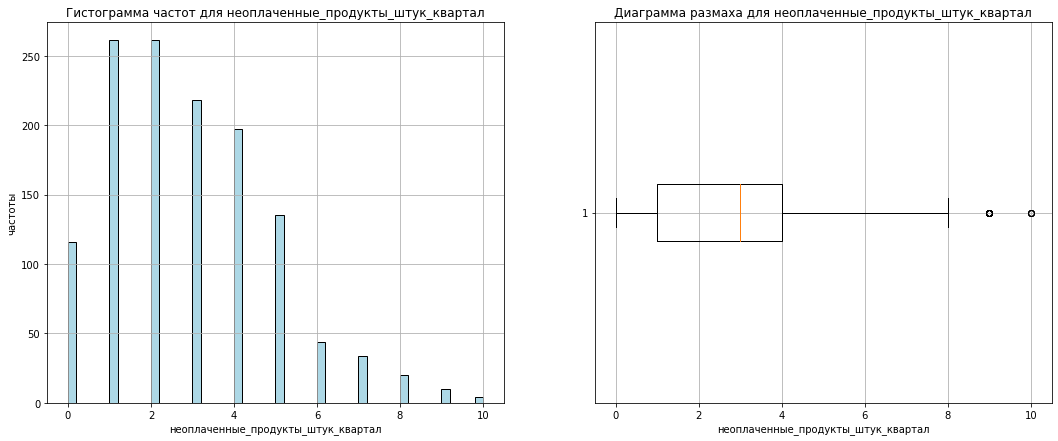

--------------------------------------------------------------------------------------------------------------

Количество выбросов 14


In [53]:
plot_hist_and_boxplot(market_file['неоплаченные_продукты_штук_квартал'])
print(f'Количество выбросов {market_file.query("неоплаченные_продукты_штук_квартал > 8")["id"].count()}')

**Здесь тоже удалять не буду, выбросы по диаграмме размаха это 9 и 10 неоплаченных продуктов за последние три месяца. Если удалить выбросы, мы потеряем эти две группы**

Теперь посмотрим на категориальные столбцы market_file

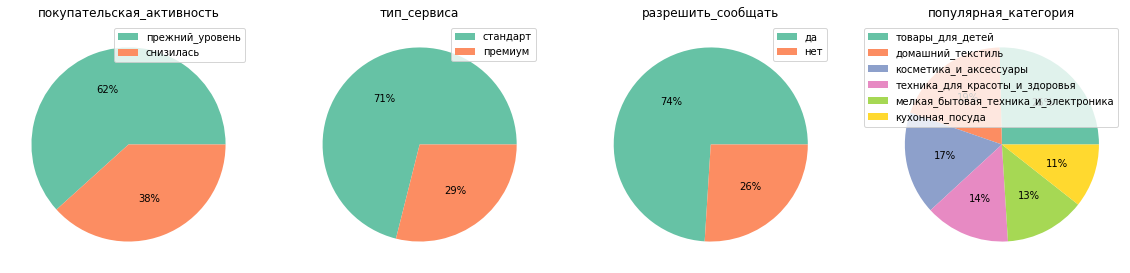

In [54]:
plot_pie(market_file)

**В датасете наблюдается дисбаланс классов. Нужно будет это учесть при построении моделей**

### Исследовательский анализ `market_money`

In [55]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [56]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Основные числовые характеристики столбца выручка:
count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64


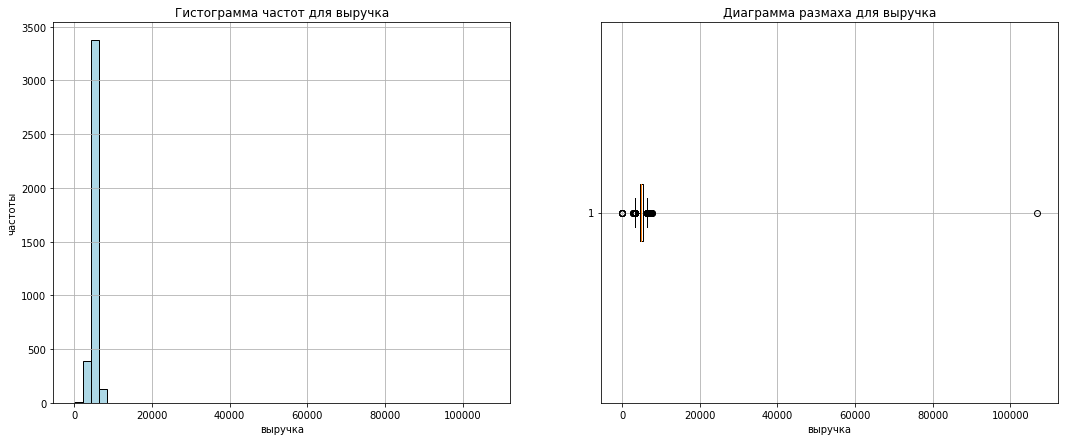

--------------------------------------------------------------------------------------------------------------

Количество выбросов больше 20000 = 1


In [57]:
plot_hist_and_boxplot(market_money['выручка'])
print(f'Количество выбросов больше 20000 = {market_money.query("выручка > 20000")["id"].count()}')

In [58]:
market_money.query('выручка > 20000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [59]:
market_money[market_money['id'] == 215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


**Прошлые два месяца этот клиент тратил по 5, 6 тыс, а в текущем потратил около 106тыс. Довольно стремительный скачок. Это аномалия. Лучше удалить клиента с этим id**

**Судя по графикам есть один единственный непомерно большой выброс. Целесообразно будет от него избавиться**

Основные числовые характеристики столбца выручка:
count    3897.000000
mean     4999.287760
std       706.970089
min         0.000000
25%      4590.000000
50%      4956.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64


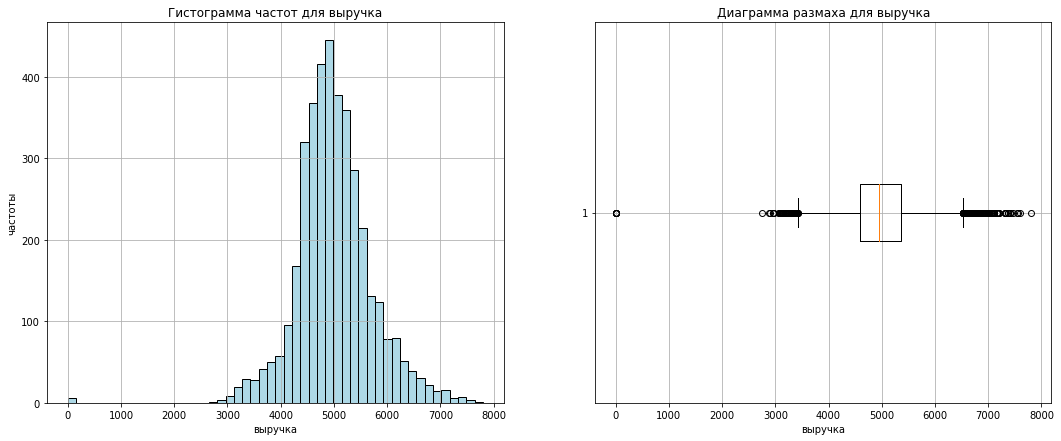

--------------------------------------------------------------------------------------------------------------

Количество выбросов где выручка нулевая  = 6


In [60]:
#цдаляем клиента с аномалией
market_money = market_money.query('id != 215380')
plot_hist_and_boxplot(market_money['выручка'])
print(f'Количество выбросов где выручка нулевая  = {market_money.query("выручка == 0")["id"].count()}')

- **`market_money` это таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Среди 3900 покупателей, трое(6 записей потому что есть предыдущий и препредыдущий месяцы для каждого id) не купили ничего и принесли нулевую выручку. Это достаточно малое число, чтобы посчитать его выбросом и удалить**


- в остальном распределение выручки очень симетричное и красивое

In [61]:
#нашлись трое клиентов не купивших ничего в прошлые два месяца. Это и есть те самые выбросы на графиках
market_money.query('выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [62]:
#но эти клиенты принесли выручку магазину в текущем месяце
market_money.query('id in [215348,215357,215359]')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


**Значит эти 3 клиента просто новые. Они купили что-то в магазине в текущем месяце, а при внесении данных им проставили нули задним числом за два прошлых месяца. Ввиду малого количества лучше будет удалить этих клиентов вовсе**

In [63]:
market_money = market_money.query('id not in [215348,215357,215359]')

In [64]:
market_money.shape

(3888, 3)

Изначально было 3900 строк, удалили 12 строк. Осталось ~ 99.69% исходного датасета 

Рассмотрим категориальный столбец

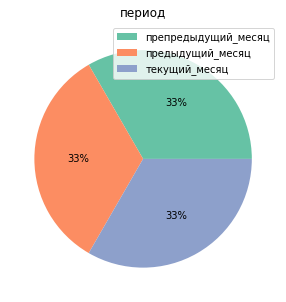

In [65]:
plot_pie(market_money)

Все верно, этих трех категорий должно быть поровну

### Исследовательский анализ `market_time`

In [66]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [67]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Основные числовые характеристики столбца минут:
count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


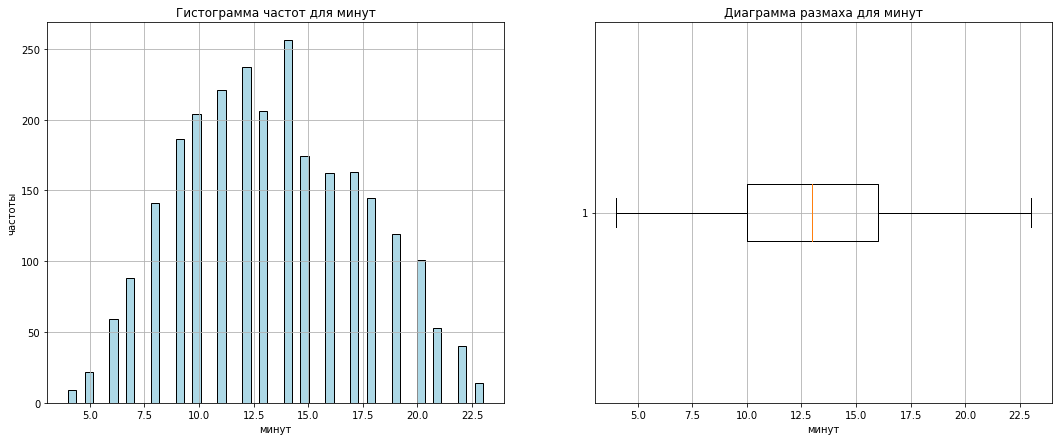

--------------------------------------------------------------------------------------------------------------



In [68]:
plot_hist_and_boxplot(market_time['минут'])

Выбросов нет. Распределение почти симметричное. Рассмотрим категориальный столбец


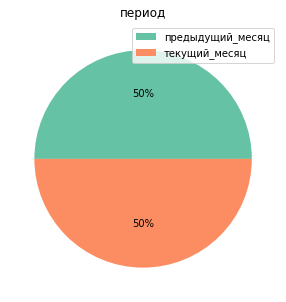

In [69]:
plot_pie(market_time)

Все верно

### Исследовательский анализ `money`

In [70]:
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [71]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Основные числовые характеристики столбца прибыль:
count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


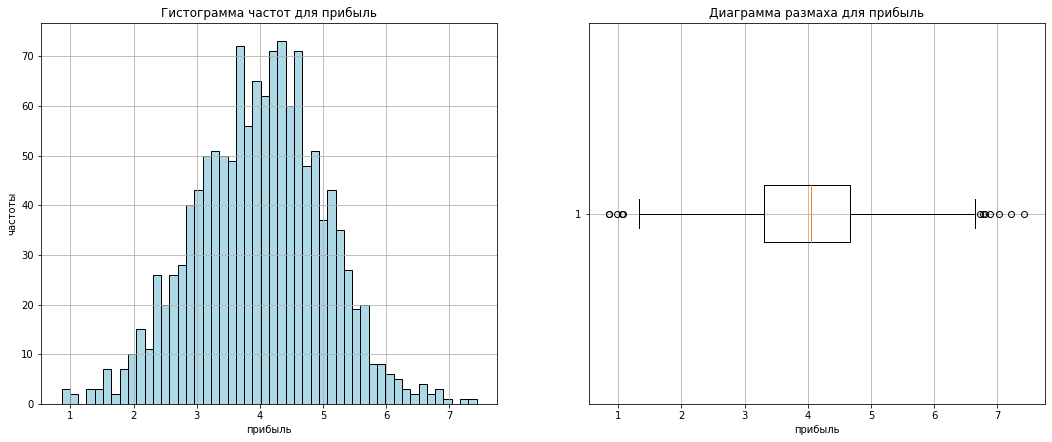

--------------------------------------------------------------------------------------------------------------



In [72]:
plot_hist_and_boxplot(money['прибыль'])

Есть выбросы на диаграмме размаха, но судя по гистограмме они не выделяются из общей структуры распределения и смотрятся в нем гармонично. Не будем удалять

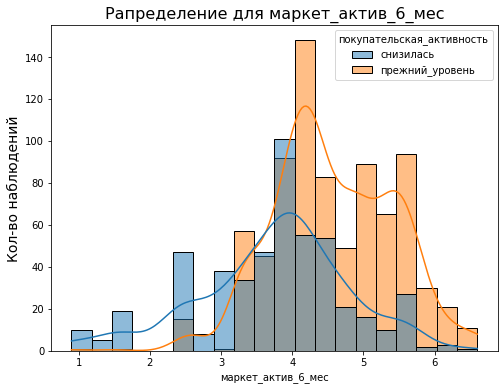

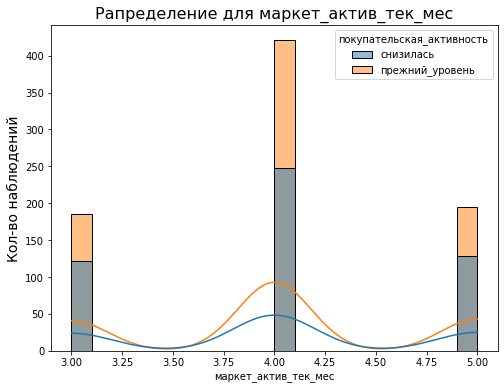

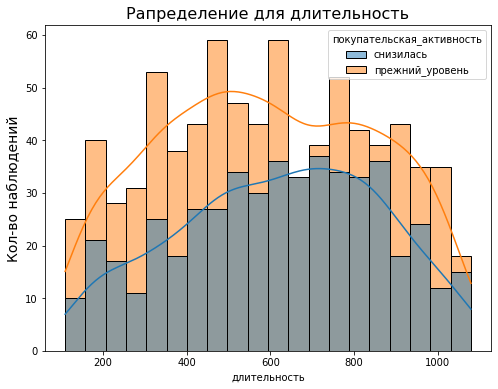

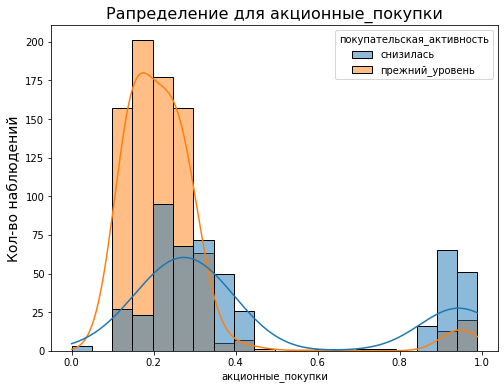

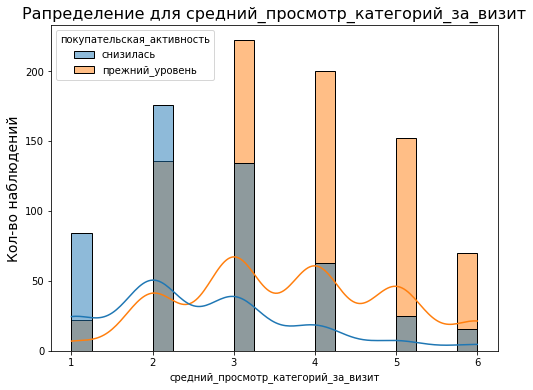

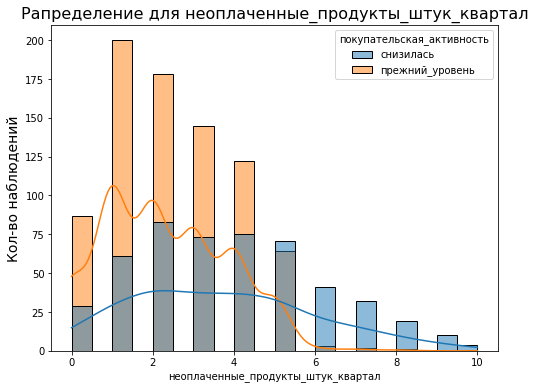

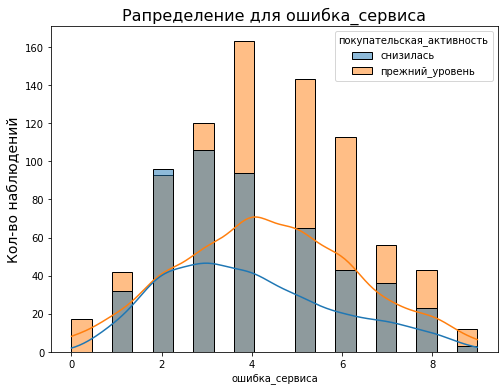

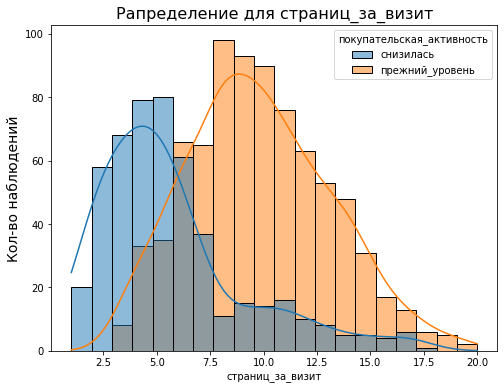

In [73]:

    
for i in market_file.drop('id', axis = 1).select_dtypes(include = 'number'):
    plot_hist(market_file, i, 'покупательская_активность')

**Для клиентов, покупательская активнось которых снизилась, характерны меньшие значения страниц за визит и средний просмотр категорий за визит. То есть клиенты, активность которых снизилась в основном стали меньше просматривать страниц сайта и категорий товара.**

**Также заметно, что среди снизивших активность клиентов гораздо больше тех, кто много товаров покупает по акции. Возможна группа любителей акционных покупок склонна снижать свою покупательскую активность**

**Среди снизивших актвиность покупателей более распространены высокие значения признака `неоплаченные_продукты_штук_квартал`. Вероятно наличие большого числа неоплаченных продуктов может сигнализировать о снижении активности**

Покупательская активность -  снизилась


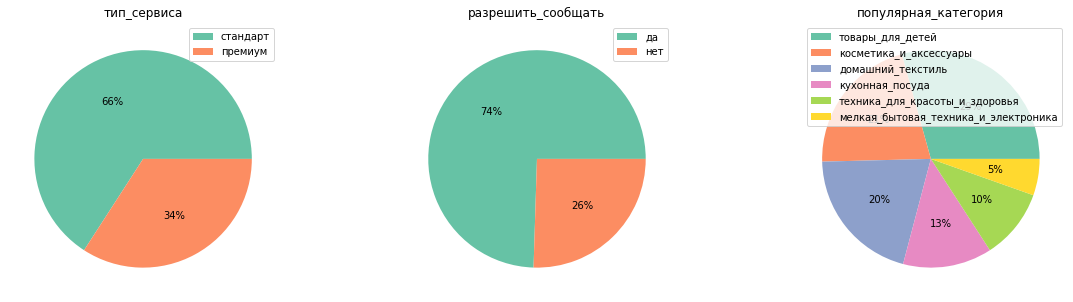

Покупательская активность -  прежний_уровень


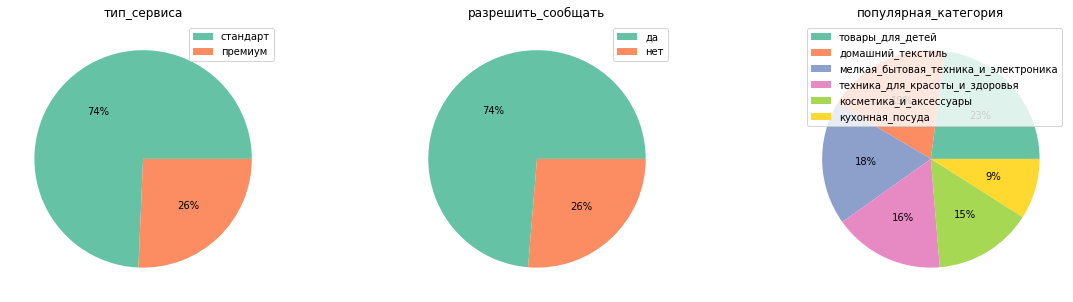

In [74]:
for i in ['снизилась', 'прежний_уровень']:
    print('Покупательская активность - ', i)
    plot_pie(market_file.query('покупательская_активность == @i').drop('покупательская_активность', axis =1))
    plt.show()

**Среди снизивших активность клиентов чуть больше типасервиса премиум и более популярны категории товара: `товары_для_детей`,`косметика_и_аксессуары`,`домашний_текстиль`. Проблемные клиенты находятся в этих сегментах**

**Вывод по разделу `Исследовательский анализ`**



- <ins>`market_file`</ins>
    - Некторые распредления имеют форму нормального или напоминают его. Например `ошибка_сервиса` и `страниц_за_визит` или `средний просмотр категорий за визит`. 
    - Акционные покупки разделяются на 2 группы. Тех, у кого среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев не превосходила 0.5, и тех, кого эта доля была выше 0.8. 
    - `длительность` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, имеет самое равномерное распределение из всех, но тем не менее у графика есть эксремум
    - Нашлось 36 выбросов за пределами усов диаграммы размаха по столбцу `маркет_актив_6_мес`. Но эти выбросы нерассеяны, а распределедяются между 4 значениями. Ввиду этого выбросы удалены не были
     - В датасете наблюдается дисбаланс классов. Нужно будет это учесть при построении моделей
     - клиенты, активность которых снизилась в основном стали меньше просматривать страниц сайта и категорий товара.Также заметно, что среди снизивших активность клиентов гораздо больше тех, кто много товаров покупает по акции. Возможна группа любителей акционных покупок склонна снижать свою покупательскую активность. Высокое число неоплаченных продуктов может сигнализировать о снижении покупательской активности
     
    
    
    

- <ins>`market_money`</ins>
    - Прошлые два месяца клиент `215380` тратил по 5, 6 тыс, а в текущем потратил около 106тыс. Довольно стремительный скачок. Это аномалия. Лучше удалить клиента с этим id
    - трое клиентов с  id [215348,215357,215359] ничего не покупали в двух прошлых месяцах, но принесли выручку в текущем месяце. Ввиду их малого количества, все четверо, включая аномального клиента `215380` были удалены везде
    
    
    
    
- <ins>`market_time`</ins>
    - Выбросов по столбцу `минут` нет. Распределение почти симметричное
    
    
    
    
- <ins>`money`</ins>
    - Есть выбросы на диаграмме размаха по столцу `прибыль`, но судя по гистограмме они не выделяются из общей структуры распределения и смотрятся в нем гармонично. Не будем удалять
    
    
    


##  Объединение таблиц

### Объединим таблицы `market_file`, `market_money`, `market_time` 

In [75]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


In [76]:
market_file.shape

(1300, 13)

In [77]:
#в ходе исследовательского анализа market_money были удалены выбросы, которые были найдены у четырех клиентов со следующими id:
deleted_id_list = [215348,215357,215359, 215380]
#следует удалить эти id из всех имеющихся таблиц
market_file = market_file.query('id not in @deleted_id_list')
market_file = market_file.reset_index(drop=True)
market_file.shape

(1296, 13)

In [78]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [79]:
market_time.shape

(2600, 3)

In [80]:
market_time = market_time.query('id not in @deleted_id_list')
market_time = market_time.reset_index(drop=True)
market_time.shape


(2592, 3)

In [81]:
market_money.head()

,id,период,выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


In [82]:
market_money = market_money.query('id not in @deleted_id_list')
market_money = market_money.reset_index(drop=True)

In [83]:
market_money.shape

(3888, 3)

**Теперь объединим таблицы `market_file` и `market_time`**

In [84]:
#сделаем market_time с индексом id
market_file = market_file.set_index('id')
market_file

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
id,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
216643,прежний_уровень,стандарт,да,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11
216644,прежний_уровень,стандарт,нет,5.1,4,454,0.21,домашний_текстиль,6,2,3,9
216645,прежний_уровень,стандарт,да,4.1,3,586,0.20,домашний_текстиль,3,2,5,7


In [85]:
#цикл добавит в market_file столбцы минут_тек и минут_пред.
#В этих столбцах будут минуты за текущий и предыдущий периоды из market_time 
for index, idd in market_time['id'].items():
    if market_time.loc[index, 'период'] == 'текущий_месяц':
        market_file.loc[idd,'минут_тек'] = market_time.loc[index, 'минут']
        
    elif market_time.loc[index, 'период'] == 'предыдущий_месяц':
        market_file.loc[idd,'минут_пред'] = market_time.loc[index,'минут']
        
    else:
        print(f"Встретилось неожиданное значение {market_time.loc[index, 'период']}")

In [86]:
market_file[['минут_тек', 'минут_пред']]

,минут_тек,минут_пред
id,,
215349,10.0,12.0
215350,13.0,8.0
215351,13.0,11.0
215352,11.0,8.0
215353,10.0,10.0
...,...,...
216643,7.0,14.0
216644,11.0,12.0
216645,18.0,12.0


In [87]:
market_time

,id,период,минут
0,215349,текущий_месяц,10
1,215349,предыдущий_месяц,12
2,215350,текущий_месяц,13
3,215350,предыдущий_месяц,8
4,215351,текущий_месяц,13
...,...,...,...
2587,216645,текущий_месяц,18
2588,216646,предыдущий_месяц,18
2589,216646,текущий_месяц,7
2590,216647,текущий_месяц,10


**Столбцы `минут_тек` и `минут_пред` были сформированы корректно. Теперь объединим `market_file`  и `market_money`:**

In [88]:
market_money.head(15)

,id,период,выручка
0,215349,препредыдущий_месяц,4472.0
1,215349,текущий_месяц,4971.6
2,215349,предыдущий_месяц,5216.0
3,215350,препредыдущий_месяц,4826.0
4,215350,текущий_месяц,5058.4
5,215350,предыдущий_месяц,5457.5
6,215351,текущий_месяц,6610.4
7,215351,предыдущий_месяц,6158.0
8,215351,препредыдущий_месяц,4793.0
9,215352,предыдущий_месяц,5807.5


In [89]:
for index, idd in market_money['id'].items():
    if market_money.loc[index,'период'] == 'текущий_месяц':
        market_file.loc[idd,'выручка_тек'] = market_money.loc[index,'выручка']
        
    elif market_money.loc[index, 'период'] == 'предыдущий_месяц':
        market_file.loc[idd, 'выручка_пред'] = market_money.loc[index, 'выручка']
        
    elif market_money.loc[index,'период'] == 'препредыдущий_месяц':
        market_file.loc[idd, 'выручка_препред'] = market_money.loc[index, 'выручка']
        
    else:
        print(f"Встретилось неожиданное значение {market_money.loc[index,'период']}")

In [90]:
market_file[['минут_тек', 'минут_пред', 'выручка_тек', 'выручка_пред', 'выручка_препред']]

,минут_тек,минут_пред,выручка_тек,выручка_пред,выручка_препред
id,,,,,
215349,10.0,12.0,4971.6,5216.0,4472.0
215350,13.0,8.0,5058.4,5457.5,4826.0
215351,13.0,11.0,6610.4,6158.0,4793.0
215352,11.0,8.0,5872.5,5807.5,4594.0
215353,10.0,10.0,5388.5,4738.5,5124.0
...,...,...,...,...,...
216643,7.0,14.0,4741.7,3664.0,4704.0
216644,11.0,12.0,5353.0,4729.0,5299.0
216645,18.0,12.0,5139.2,5160.0,5334.0


**Все колонки добавились корректно**

**Вывод по разделу `Объединение таблиц`**
- изначально в `market_money` были найдены три клиента, которые покупали только в текущем месяце, и один аномальный клиент выручка от которого в текущем месяце вдруг увеличилась более чем в 15 раз по сравнению с предыдущими месяцами. Теперь перед объединением талбиц эти 4 клиента были удалены из трех остальных датасетов 
- Сначала добавил в `market_file` столбцы `минут_тек` и `минут_пред`.В этих столбцах будут минуты за текущий и предыдущий периоды из `market_time`
- Потом также в `market_file` были добавлены `выручка_тек`, `выручка_пред`,	`выручка_препред` содержащие информацию из `market_money` о выручке за соответствующие периоды

## Корреляционный анализ

Теперь главный датасет объединяющий в себе всю информацию `market_file`

In [91]:
market_file.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,10.0,12.0,4472.0,4971.6,5216.0
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,13.0,8.0,4826.0,5058.4,5457.5
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,13.0,11.0,4793.0,6610.4,6158.0
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,11.0,8.0,4594.0,5872.5,5807.5
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,10.0,10.0,5124.0,5388.5,4738.5


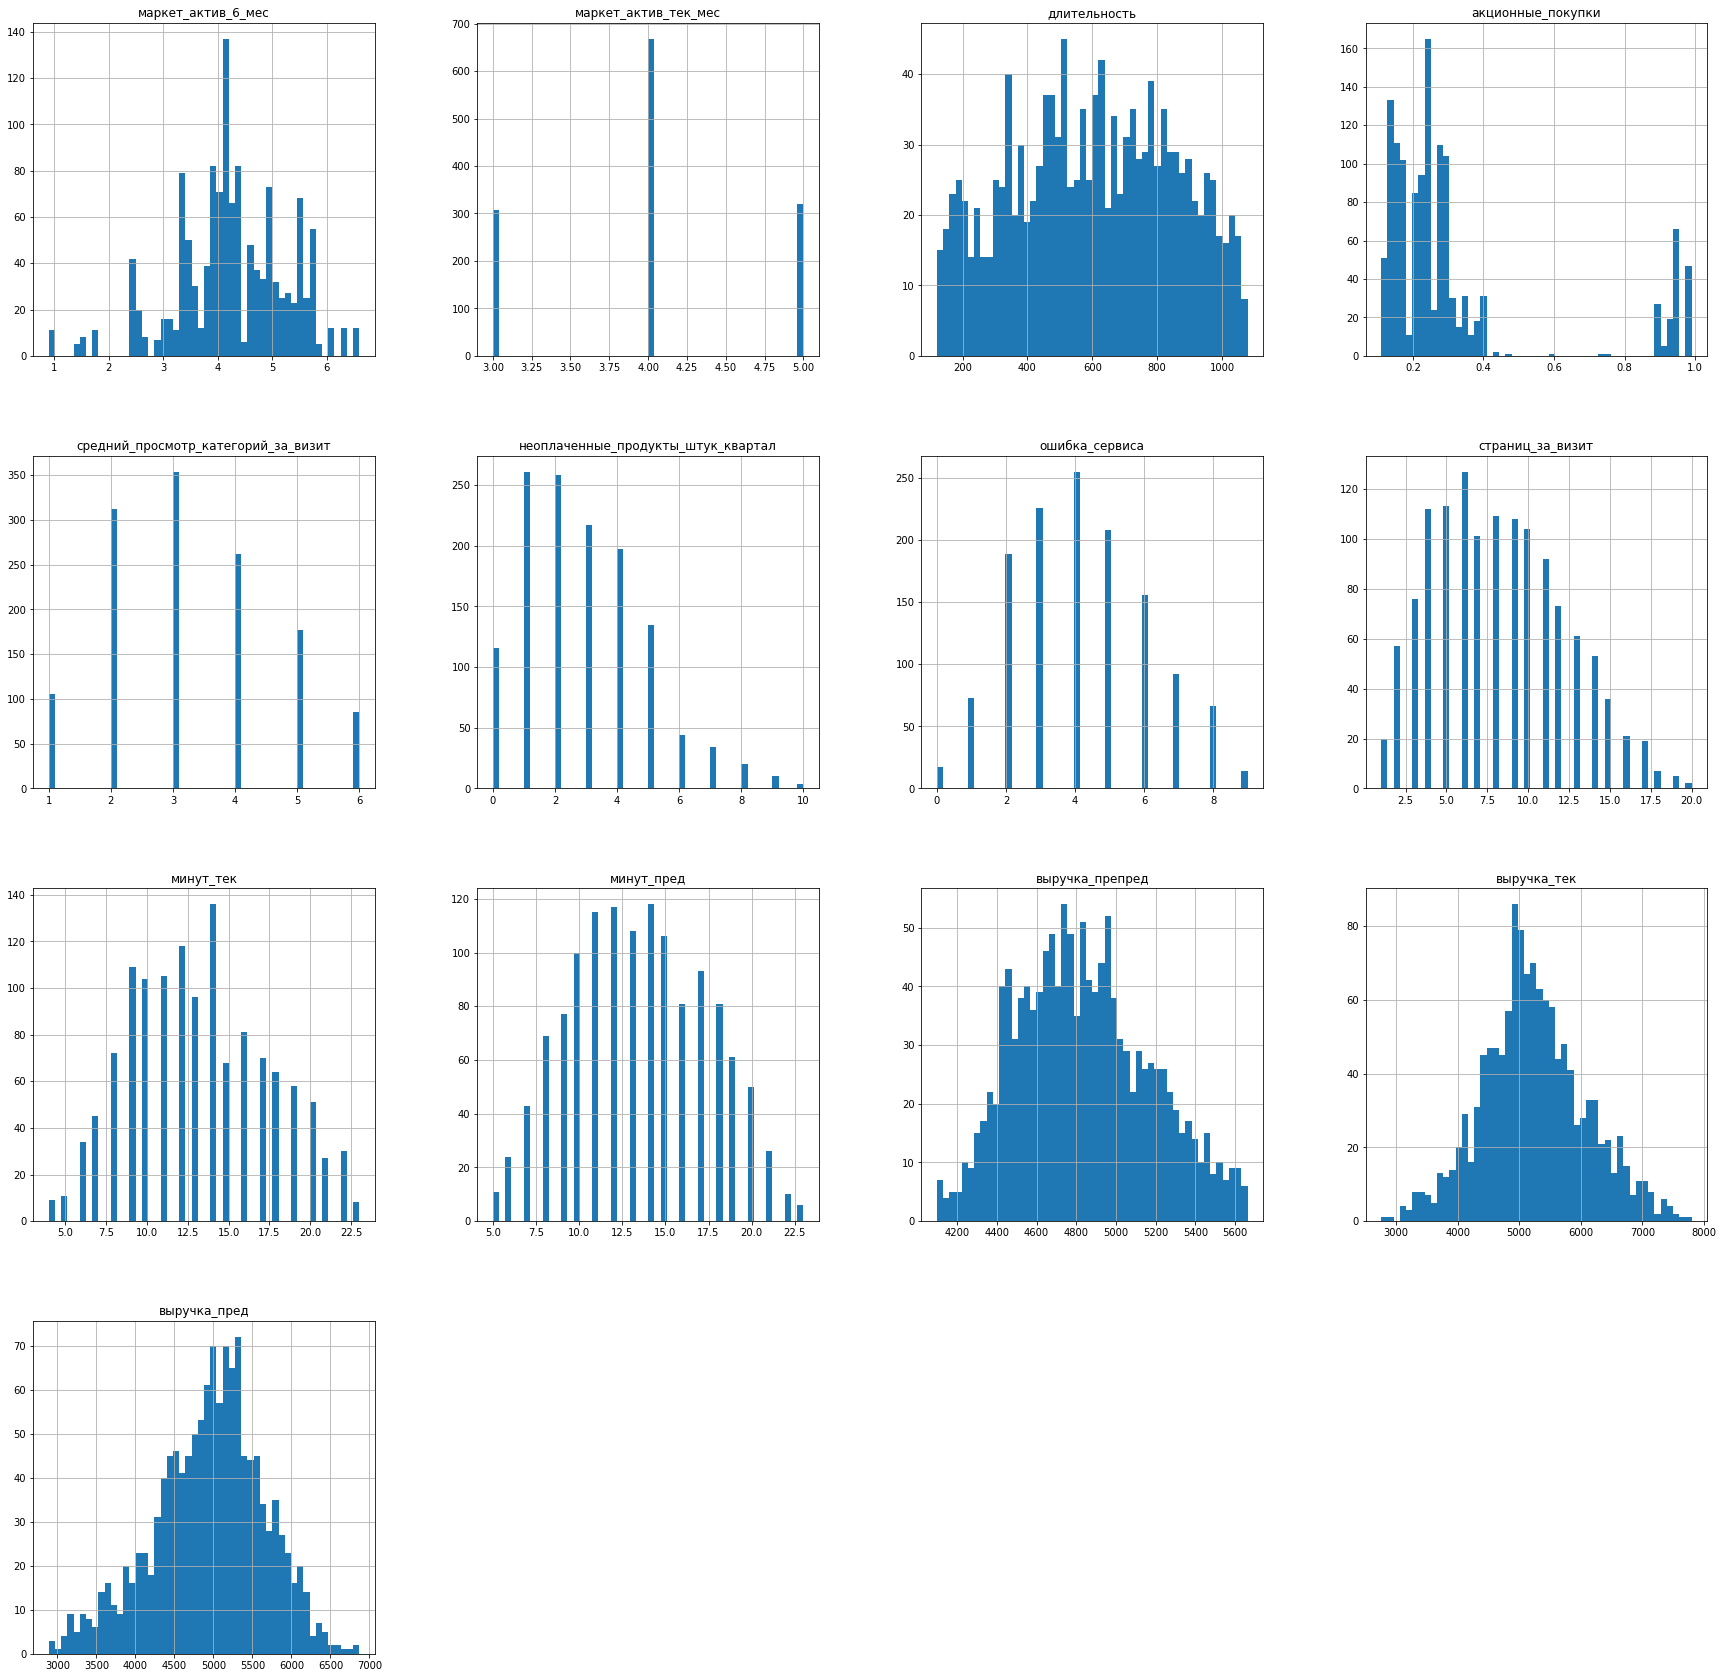

In [92]:
market_file.hist(figsize = (30,30), bins = 50)
plt.show()

Большинство признаков `market_file` имеют нормальное распределение, но `акционные покупки` расходятся на две группы, а распределение `неоплаченные_продукты_шт_квартал`, `cтраниц_за_визит` и `минут_тек` cмещены влево. Поскольку не все признаки имеют нормальное распределение, не следует считать корреляцию Пирсона. Вместо нее посчитаем корреляцию Спирмана

In [93]:
market_file.corr(method = 'spearman').style.background_gradient(cmap = 'coolwarm')

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред
маркет_актив_6_мес,1.000000,0.061741,-0.044445,-0.276590,0.185013,-0.135045,0.038643,0.319872,0.226968,0.273727,0.234728,0.002093,-0.003642
маркет_актив_тек_мес,0.061741,1.000000,-0.131967,0.033099,-0.025167,0.061747,0.087343,0.003143,-0.063051,0.013535,-0.039437,-0.011782,-0.027088
длительность,-0.044445,-0.131967,1.000000,0.029045,-0.043154,-0.108787,0.103562,-0.034495,0.083048,-0.123940,-0.039301,0.015002,0.013537
акционные_покупки,-0.276590,0.033099,0.029045,1.000000,-0.203401,0.198307,-0.051593,-0.370860,-0.275313,-0.332548,-0.269087,0.022255,0.005184
средний_просмотр_категорий_за_визит,0.185013,-0.025167,-0.043154,-0.203401,1.000000,-0.251559,0.010034,0.267479,0.233369,0.148279,0.149742,-0.070716,-0.049460
неоплаченные_продукты_штук_квартал,-0.135045,0.061747,-0.108787,0.198307,-0.251559,1.000000,-0.098582,-0.165412,-0.214699,-0.183575,-0.249293,0.061178,0.033434
ошибка_сервиса,0.038643,0.087343,0.103562,-0.051593,0.010034,-0.098582,1.000000,0.104482,0.078074,0.196009,0.090152,0.040477,0.035476
страниц_за_визит,0.319872,0.003143,-0.034495,-0.370860,0.267479,-0.165412,0.104482,1.000000,0.298120,0.450760,0.311675,-0.049964,-0.067610
минут_тек,0.226968,-0.063051,0.083048,-0.275313,0.233369,-0.214699,0.078074,0.298120,1.000000,0.360471,0.299783,-0.164851,-0.083214
минут_пред,0.273727,0.013535,-0.123940,-0.332548,0.148279,-0.183575,0.196009,0.450760,0.360471,1.000000,0.348745,-0.143371,-0.084215


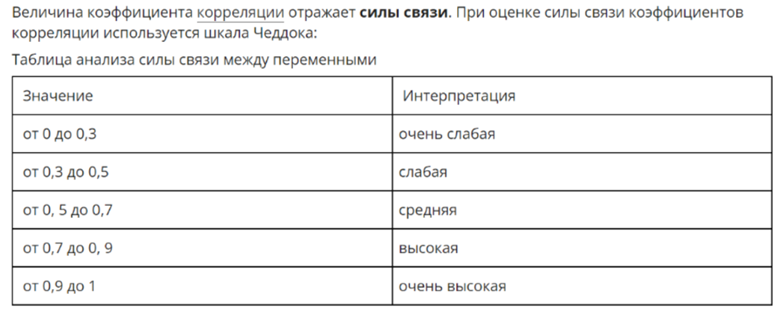

**Вывод по разделу `Корреляционный анализ`**
- Самую высокую корреляцию имеет пара признаков `выручка_тек`и  `выручка_пред`. Выручка в текущем и предыдущем месяце соответсвенно. Коэффициент корреляции между этими двумя признаками `(0.879097)` практически подобрался к пограничному значению мультиколинеарности 0.9. Однако у обоих признаковн не наблюдается такой корреляции с `выручкой_препред`. Там коэффициенты `(0.149944)` и `(0.308041)`. Учитывая такую сильную корреляцию между выручкой в текущем месяце и выручкой в предыдущем месяце, а также то, что текущий месяц может быть еще не закончен, а значит на данные момент данные за него не полные, возможно лучше удалить признак `выручка_тек`. Либо попробовать обучить модель с ним и без него и посмотреть на метрики качества



- слабую связь по шкале Чеддока имеют такие признаки как :
    - страниц_за_визит, маркет_актив_6_мес (0.319872)
    - страниц_за_визит, минут_пред	(0.450760)
    - страниц_за_визит, выручка_препред (0.311675)
    - страниц_за_визит, акционные_покупки (-0.370860)
    - минут_пред, выручка_препред (0.348745)
    - минут_тек, минут_пред (0.360471)
    
    
    
    
- остальные признаки имеют очень слабую корреляцию

## Использование пайплайнов

In [94]:
market_file.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,10.0,12.0,4472.0,4971.6,5216.0
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,13.0,8.0,4826.0,5058.4,5457.5
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,13.0,11.0,4793.0,6610.4,6158.0
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,11.0,8.0,4594.0,5872.5,5807.5
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,10.0,10.0,5124.0,5388.5,4738.5


In [95]:
market_file['покупательская_активность'].value_counts()

прежний_уровень    802
снизилась          494
Name: покупательская_активность, dtype: int64

Целевой признак - `Покупательская активность`. Закодируем снизилась - 0, прежний_уровень  - 1. Также можно разбить `акционные_покупки` на две группы(редко и часто), которые можно увидеть на построенных гистограммах

In [96]:
market_file['покупательская_активность'] = (market_file['покупательская_активность']
                                            .apply(lambda x: 1 if x == 'прежний_уровень' else 0))


market_file['акционные_покупки'] = (market_file['акционные_покупки']
                                    .apply(lambda x: 'редко' if x <= 0.65 else 'часто'))

print(market_file['покупательская_активность'].value_counts())

market_file['акционные_покупки'].value_counts()

1    802
0    494
Name: покупательская_активность, dtype: int64


редко    1130
часто     166
Name: акционные_покупки, dtype: int64

In [97]:
#разбиваем на тренировочную и тестовую выборки с учетом дисбаланса классов
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    market_file.drop(['покупательская_активность'], axis= 1),
    market_file['покупательская_активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = market_file['покупательская_активность']
)
print(X_train.shape, X_test.shape)

(972, 16) (324, 16)


In [98]:
#отделяеи признаки для кодирования
ohe_columns = ['популярная_категория', 'разрешить_сообщать']
ord_columns = ['акционные_покупки', 'тип_сервиса']

num_columns = list(market_file.drop('покупательская_активность', axis = 1).select_dtypes(exclude = 'object').columns)
num_columns

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'минут_тек',
 'минут_пред',
 'выручка_препред',
 'выручка_тек',
 'выручка_пред']

**Напишем наконец полный пайплайн. В качечтве метрики будет использован показатель `ROC_AUC` чтобы оценивать эффективность модели независимо от порогов классификации. Также эта метрика подходит при дисбалансе классов**

In [99]:
warnings.filterwarnings('ignore')

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))  
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
     ('ord', OrdinalEncoder(categories = [['редко', 'часто'],
                                         ['стандарт', 'премиум']],
                           handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)    
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', LogisticRegression(random_state = RANDOM_STATE))  
    ]
)

param_grid = [
    {
        'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,6),
        'models__max_features' : range(2,6),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models' : [LogisticRegression(random_state = RANDOM_STATE, class_weight = 'balanced')],
        'models__C' : range(1, 5),
        'models__penalty' : ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models' : [KNeighborsClassifier()],
        'models__n_neighbors' : range(2,6),
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), 'passthrough']},
    {
        'models' : [SVC(random_state = RANDOM_STATE, probability=True)],
        'models__kernel' : ['rbf', 'linear', 'sigmoid', 'poly'],
        'models__degree' : range(1,10),
        'models__C' : range(1, 5)
    }
    
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring= 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1,
)

randomized_search.fit(X_train,y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['популярная_категория',
                        

In [100]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кроссвалидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                   

In [101]:
randomized_search.best_params_

{'models__kernel': 'rbf',
 'models__degree': 3,
 'models__C': 4,
 'models': SVC(C=4, probability=True, random_state=42)}

**В пайплайне были перебраны методом случайного перебора 4 модели машинного обучения. Логистическая регрессия, метод опорных векторов, дерево решений и метод k-ближайших соседей**


- Для дерева решений перебирались параметры максимальной глубины и кол-во учитываемых при разбиении признаков


- Для логистической регрессии перебирались два типа регуляризации l1 и l2, а также сила модели 


- Для k-ближайших соседей перебиралось число ближайших соседей


- Для метода опорных векторов перебирались: ядро('rbf', 'linear', 'sigmoid', 'poly'), а также степень и сила модели



**Лучшей моделью на кроссвалидации, показавшей метрику `ROC_AUC ~0.9144`, стала SVM с параметрами:**
- ядро радиальной базисной функции
- сила модели 4


In [102]:
y_test_pred_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9033870967741935


**На тестовых данных отобранная модель показал себя также хорошо `ROC_AUC 0.9034`.**

In [103]:
result = (pd.DataFrame(randomized_search.cv_results_)[['rank_test_score', 'param_models', 
                                                       'mean_test_score','params', 'mean_test_score',
                                                       'param_preprocessor__num']]
          .sort_values(by = 'rank_test_score'))
result

,rank_test_score,param_models,mean_test_score,params,mean_test_score,param_preprocessor__num
3,1,"SVC(C=4, probability=True, random_state=42)",0.914357,"{'models__kernel': 'rbf', 'models__degree': 3,...",0.914357,NaN
5,2,"SVC(C=4, probability=True, random_state=42)",0.901941,"{'models__kernel': 'linear', 'models__degree':...",0.901941,NaN
7,2,"SVC(C=4, probability=True, random_state=42)",0.901941,"{'models__kernel': 'linear', 'models__degree':...",0.901941,NaN
8,4,"SVC(C=4, probability=True, random_state=42)",0.865301,"{'models__kernel': 'sigmoid', 'models__degree'...",0.865301,NaN
9,4,"SVC(C=4, probability=True, random_state=42)",0.865301,"{'models__kernel': 'sigmoid', 'models__degree'...",0.865301,NaN
0,6,"SVC(C=4, probability=True, random_state=42)",0.852144,"{'models__kernel': 'poly', 'models__degree': 6...",0.852144,NaN
6,7,DecisionTreeClassifier(random_state=42),0.818317,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.818317,MinMaxScaler()
4,8,DecisionTreeClassifier(random_state=42),0.767627,"{'preprocessor__num': StandardScaler(), 'model...",0.767627,StandardScaler()
2,9,DecisionTreeClassifier(random_state=42),0.747829,"{'preprocessor__num': StandardScaler(), 'model...",0.747829,StandardScaler()
1,10,"LogisticRegression(class_weight='balanced', ra...",NaN,"{'preprocessor__num': StandardScaler(), 'model...",NaN,StandardScaler()


**Выведем отдельно параметры моделей второго места. Заметим также что у лучших моделей масштабирование числовых данных вовсе не производилось**

In [104]:
for i in result.query('rank_test_score == 2')['params']:
    print(i)

{'models__kernel': 'linear', 'models__degree': 2, 'models__C': 4, 'models': SVC(C=4, probability=True, random_state=42)}
{'models__kernel': 'linear', 'models__degree': 1, 'models__C': 4, 'models': SVC(C=4, probability=True, random_state=42)}


**На втором месте по среднему значению `ROC_AUC 0.901941` находится SVM c линейным ядром и силой модели C=4. Степень degree роли не играет, поскольку у нас линейное ядро. Линейная модель SVM проще и хуже модели лидера всего на 1.3%**

**Вывод по разделу `Использование пайплайнов`**
- **В пайплайне были перебраны методом случайного перебора 4 модели машинного обучения. Логистическая регрессия, метод опорных векторов, дерево решений и метод k-ближайших соседей**
    - Для дерева решений перебирались параметры максимальной глубины и кол-во учитываемых при разбиении признаков
    - Для логистической регрессии перебирались два типа регуляризации l1 и l2, а также сила модели 
    - Для k-ближайших соседей перебиралось число ближайших соседей
    - Для метода опорных векторов перебирались: ядро('rbf', 'linear', 'sigmoid', 'poly'), а также степень и сила модели



- **Лучшей моделью на кроссвалидации, показавшей метрику `ROC_AUC ~0.9144`, стала SVM с параметрами:**
    - ядро радиальной базисной функции
    - сила модели 4



- **Остановимся на лучшей модели `SVM ядро радиальной базисной функции, сила модели 4`, показавшей среднее значение метрики `ROC_AUC 0.914357` при кроссвалидации и `ROC_AUC 0.9034` на тестовых данных**

##  Анализ важности признаков

**Создадим таблицы с преобразованными признаками**

In [105]:
X_train2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test2 = pipe_final.named_steps['preprocessor'].transform(X_test)

ohe_feature_names = (pipe_final.named_steps['preprocessor'].transformers_[0][1]
                     .named_steps['ohe'].get_feature_names(ohe_columns).tolist())

columns = ohe_feature_names + ord_columns + num_columns


X_train2 = pd.DataFrame(X_train2, columns = columns)


X_test2 = pd.DataFrame(X_train2, columns = columns)
X_test2

,популярная_категория_косметика_и_аксесcуары,популярная_категория_кухонная_посуда,популярная_категория_мелкая_бытовая_техника_и_электроника,популярная_категория_техника_для_красоты_и_здоровья,популярная_категория_товары_для_детей,разрешить_сообщать_нет,акционные_покупки,тип_сервиса,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.416141,-0.041640,-0.140932,1.300196,-0.916299,-0.077381,0.963226,1.118730,-0.398744,0.565381,-1.803557,-0.976982
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.848631,1.403854,-1.007186,1.300196,-0.916299,0.945945,-0.047849,-0.069691,0.364207,0.343539,-0.274983,-0.856667
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.242504,-0.041640,-0.169267,-0.196300,0.086677,1.457608,-1.058924,-1.020428,-1.416011,-0.357961,0.477419,0.440615
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.144036,-0.041640,-1.812722,2.048444,0.588165,-1.100708,-0.806155,-0.307376,-1.416011,-0.855607,-0.735148,-0.974151
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.219204,1.403854,-0.238082,0.551948,-0.916299,0.945945,-0.806155,-0.545060,-0.398744,1.164954,0.510577,0.630996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.454758,-0.041640,0.118135,0.551948,-0.916299,1.457608,1.974300,-0.069691,0.364207,-0.597790,0.407420,0.178752
968,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.037584,1.403854,1.761590,1.300196,-0.414811,1.457608,-0.806155,1.594098,0.872840,-0.468882,0.641543,0.356394
969,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.219204,-0.041640,0.733419,-0.196300,-0.916299,0.945945,0.204919,-0.545060,0.109890,0.034759,-0.323472,-0.148930
970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.651694,-0.041640,-1.229822,-0.196300,1.089653,-1.100708,1.721532,-0.782744,1.381474,-0.304000,0.385553,0.268635


In [106]:
best_model = randomized_search.best_estimator_.named_steps['models']
best_model

SVC(C=4, probability=True, random_state=42)

In [107]:
#сделаем случайные выборки из X_train2 и X_test2 по сто значений, чтобы KernelExplainer не так долго считал.
X_train_sample = shap.sample(X_train2, 100, random_state = RANDOM_STATE)
X_test_sample = shap.sample(X_test2, 100, random_state = RANDOM_STATE)
X_test_sample

,популярная_категория_косметика_и_аксесcуары,популярная_категория_кухонная_посуда,популярная_категория_мелкая_бытовая_техника_и_электроника,популярная_категория_техника_для_красоты_и_здоровья,популярная_категория_товары_для_детей,разрешить_сообщать_нет,акционные_покупки,тип_сервиса,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред
767,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.848631,-0.041640,0.834617,-0.196300,1.089653,1.969272,-0.553387,-0.545060,-0.907377,-0.235049,0.528522,1.237527
70,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,-0.257821,1.403854,1.239409,0.551948,1.089653,-0.589044,0.963226,-0.782744,0.364207,1.045040,-0.930646,-0.314540
855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.219204,-0.041640,0.101943,-0.196300,0.086677,1.457608,-0.806155,0.167993,-0.144427,1.473735,-0.122387,0.294821
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.219204,-0.041640,-1.739860,0.551948,1.089653,-0.589044,0.710457,1.594098,1.890108,0.016772,0.544566,0.400982
644,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136052,-0.041640,-0.007350,-0.944548,0.086677,0.434282,-0.806155,-0.307376,-1.161694,-0.636763,0.128612,0.678415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.750163,1.403854,0.474352,-0.944548,1.591141,1.457608,-1.311693,-1.020428,-0.907377,-1.155393,-2.334552,-2.592039
603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.120736,-0.041640,1.077492,2.048444,-0.414811,-0.077381,0.963226,0.167993,0.109890,-0.393936,-1.831129,-1.204874
716,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.022267,-1.487134,0.745562,2.048444,0.588165,-1.100708,-0.047849,1.118730,0.364207,0.481441,-0.047040,0.783868
825,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.628394,-0.041640,-0.371663,-0.944548,-0.916299,0.945945,-0.047849,1.118730,0.872840,-0.465884,1.587780,0.960802


In [108]:
explainer = shap.KernelExplainer(best_model.predict, X_train_sample)
shap_values = explainer(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

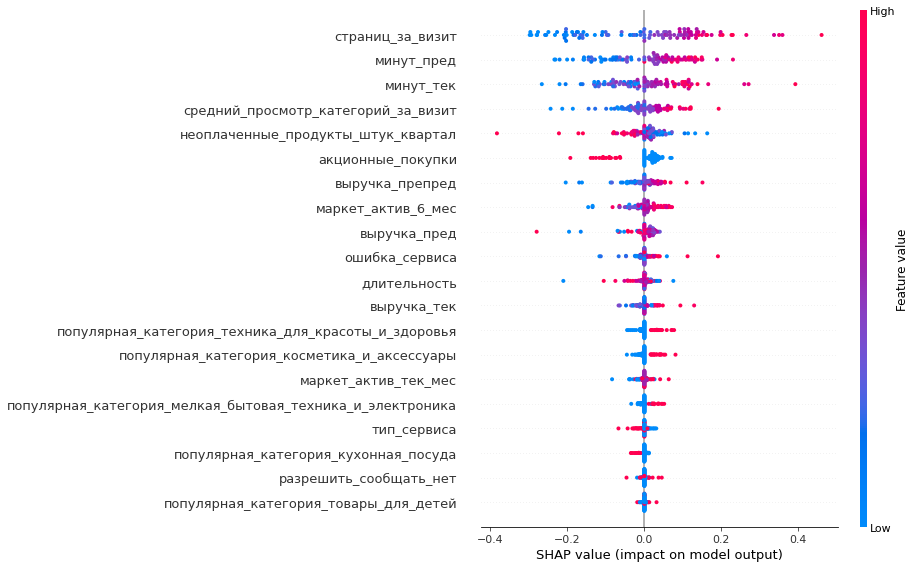

In [109]:
shap.plots.beeswarm(shap_values, max_display = 21) 

Высокие значения признаков: `страниц_за_визит`, `минут_пред`, `минут_тек`, `средний_просмотр_категорий_за_визит`, `выручка_перпред`, `маркет_актив_6_мес`, `популярная_категория_красота_и_здоровье_косметика_и_аксессуары_бытовая_техника_и_электроника`, а также `маркет_актив_тек_мес` - склоняют модель к присвоению класса 1, то есть покупательская активность останется на прежнем уровне. Низкие значения этих признаков наоборот означают, что вероятнее всего покупательская активность снизилась.


Высокие значения признаков: `неоплаченные_продукты_штук_квартал`, `акционные_покупки`, `тип_сервиса`, `популярная_категория_кухонная_посуда` склоняют модель к присвоению класса - активность снизилась. Для признака `тип_сервиса` это значит, что клиенты с премиум подпиской склонны снижать свою покупательскую активность. То же относится к любителям акционных покупок и кухонной посуды. 




**Построим график важности признаков**

In [110]:
#составим датасет c shap values
shap_df = pd.DataFrame(shap_values.values, columns= columns)
shap_df[columns] = shap_df[columns].abs()
shap_df

,популярная_категория_косметика_и_аксесcуары,популярная_категория_кухонная_посуда,популярная_категория_мелкая_бытовая_техника_и_электроника,популярная_категория_техника_для_красоты_и_здоровья,популярная_категория_товары_для_детей,разрешить_сообщать_нет,акционные_покупки,тип_сервиса,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред
0,0.000000,0.000000,0.007754,0.002120,0.000000,0.012773,0.125602,0.027809,0.038038,0.000000,0.004659,0.006850,0.053400,0.020995,0.160509,0.040793,0.100738,0.009487,0.010171,0.010291
1,0.000000,0.000000,0.000000,0.045851,0.000000,0.000000,0.075642,0.000000,0.000000,0.005144,0.004987,0.037010,0.025189,0.000000,0.336859,0.022824,0.038917,0.042324,0.000000,0.022563
2,0.016688,0.008498,0.000000,0.000000,0.000000,0.000000,0.070880,0.013112,0.051230,0.007480,0.001715,0.014790,0.051416,0.029367,0.020413,0.035854,0.036770,0.068131,0.000000,0.024481
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018759,0.000000,0.058385,0.006717,0.000000,0.038149,0.000000,0.000000,0.102962,0.099992,0.071106,0.005439,0.000000,0.008491
4,0.054254,0.000000,0.002306,0.009158,0.000000,0.000000,0.000000,0.000000,0.006816,0.000000,0.009569,0.057407,0.000000,0.000000,0.204045,0.085003,0.220178,0.042149,0.007623,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.003218,0.004713,0.001779,0.011808,0.000000,0.000000,0.029246,0.000000,0.023218,0.039363,0.075176,0.035536,0.172357,0.042282,0.128229,0.024539,0.006223,0.063386
96,0.000000,0.000000,0.022314,0.000000,0.000000,0.001235,0.025269,0.001580,0.026859,0.000000,0.000000,0.120358,0.017004,0.000000,0.133771,0.019070,0.032245,0.006459,0.000000,0.003836
97,0.000000,0.003068,0.002865,0.000000,0.000000,0.000000,0.018218,0.000000,0.063522,0.000000,0.008538,0.068859,0.005619,0.008302,0.048565,0.104059,0.044735,0.022415,0.000000,0.011234
98,0.025239,0.005011,0.000000,0.000000,0.000000,0.005515,0.020997,0.000000,0.010972,0.003104,0.005970,0.000000,0.022164,0.003351,0.037035,0.115057,0.121761,0.000000,0.028725,0.005098


In [111]:
#вычислим средние shap значения для каждого признака и отсортируем
shap_df_mean = pd.Series(shap_df.mean().values)
shap_df_mean.index = columns
shap_df_mean = shap_df_mean.sort_values()
shap_df_mean

популярная_категория_товары_для_детей                        0.001978
разрешить_сообщать_нет                                       0.003361
популярная_категория_кухонная_посуда                         0.003809
тип_сервиса                                                  0.006467
популярная_категория_мелкая_бытовая_техника_и_электроника    0.007765
маркет_актив_тек_мес                                         0.007845
популярная_категория_косметика_и_аксесcуары                  0.010430
популярная_категория_техника_для_красоты_и_здоровья          0.011403
выручка_тек                                                  0.013141
длительность                                                 0.013923
ошибка_сервиса                                               0.015106
выручка_пред                                                 0.022888
маркет_актив_6_мес                                           0.027517
выручка_препред                                              0.028559
акционные_покупки   

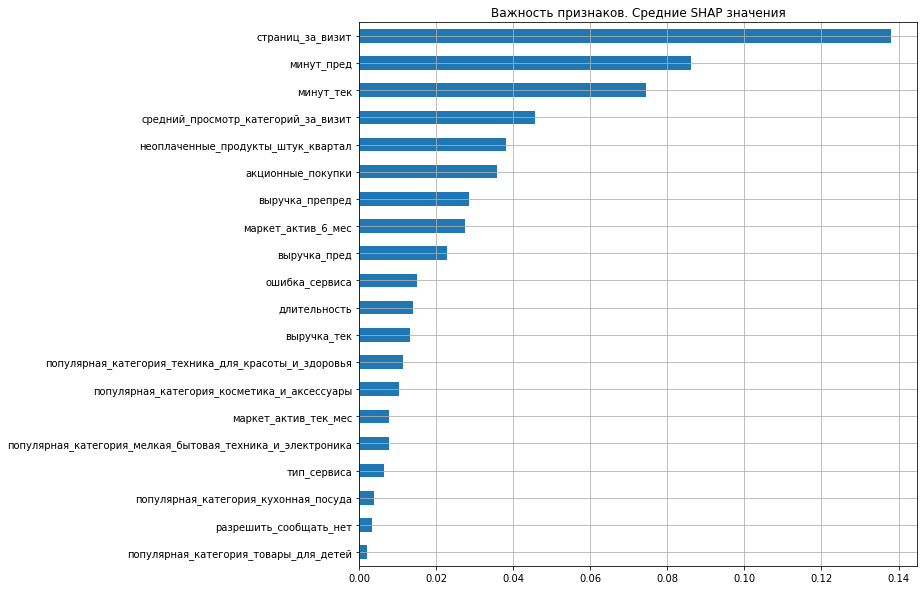

In [112]:
plt.title('Важность признаков. Средние SHAP значения')
shap_df_mean.plot(kind ='barh', figsize = (10,10), grid =True)
plt.show()

**Признаки проранжировались по важности также как на предыдущем графике beeswarm**

**Вывод по разделу `Анализ важности признаков`**

- Малозначимыми для модели можно считать признаки: 
    - `популярная категория товары для детей, кухонная посуда и бытовая техника и электроника`
    - `разрешить_сообщать`
    - `тип сервиса`
    - `маркет актив тек мес`

- Средним уровнем значимости обладаютпризнаки:
    - `популярная категория косметика и аксессуары, техника для красоты и здоровья`
    - `выручка тек`
    - `длительность`
    - `ошибка сервиса`
    
    
- Наибольшей важностью (по возрастанию) обладают:
    - `выручка пред`
    - `маркет актив 6 мес`
    - `выручка препред`
    - `акционные покупки`
    - `неоплаченные продукты штук квартал`
    - `средний просмотр категорий за визит`
    - `минут тек`
    - `минут пред`
    - `страниц за визит`
    
- Тройка особенно важных признаков(по возрастанию):
    - `минут тек`
    - `минут пред`
    - `страниц за визит`
    
    
Прежде всего заказчику следует обратить внимание на тройку лидеров по важности.Более высокие значения этих признаков вероятны для тех клиентов, покупательская активность которых останется на прежнем уровне. Иными словами не стоит переживать за клиентов которые за последние три месяца в среднем  просматривали страниц больше других. То же относится клиентам, проводившим много времени на сайте в текущем и предыдущем месяцах.


**Однако низкие значения тройки лидеров уже повод обеспокоиться вероятным снижением покупательской активности**


Еще одним хорошим индикатором активности выступает признак `средний просмотр категорий за визит`. Низкие значения этого признака сигнализируют о снижении покупательской активности. Стремиться следует к высоким значениям



Также следует обратить внимание на признаки `акционные покупки` и `неоплаченные продукты штук квартал`. Заказчику нужно стремиться к низким значениям этих показателей, чтобы как можно меньше клиентов снижали свою активность. Высокие значения этих признаков ведут к снижению покупатльской активности. Выделенная ранее группа покупателей, склонных к акционным покупкам, на shap besswarm тоже выглядит сепарированно. Это значит, что любители акционных покупок склонны снижать свою активность. Возможно причина в том, что у магазина стало мало акционных предложений. Стоит подумать о расширении персональных акций для этой группы покупателей. 




## Сегментация покупателей

**Ранее я высказывал предположение о том, что любители акционных покупок склонны снижать свою покупательскую активность. В дополнительном исследовании хочется проверить это предположение и рассмотреть его подробнее. Для начала объединим данные о среднемесячной прибыли от покупателя за три месяца, предсказанные вероятности принадлежности к классам и остальную информацию**

In [113]:
market_file.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред
id,,,,,,,,,,,,,,,,,
215349,0,премиум,да,4.4,4,819,часто,товары_для_детей,4,4,2,5,10.0,12.0,4472.0,4971.6,5216.0
215350,0,стандарт,нет,4.9,3,539,редко,домашний_текстиль,5,2,1,5,13.0,8.0,4826.0,5058.4,5457.5
215351,0,стандарт,да,3.2,5,896,часто,товары_для_детей,5,0,6,4,13.0,11.0,4793.0,6610.4,6158.0
215352,0,стандарт,нет,5.1,3,1064,часто,товары_для_детей,3,2,3,2,11.0,8.0,4594.0,5872.5,5807.5
215353,0,стандарт,да,3.3,4,762,редко,домашний_текстиль,4,1,1,4,10.0,10.0,5124.0,5388.5,4738.5


In [114]:
money.head()

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [115]:
#в test proba будет предсказанная на тестовых данных веротность класса 0. Т.е сниженная активность
test_proba = randomized_search.predict_proba(X_test)[:,0]
test = X_test.copy()
test['снизилась_активность_вероятность'] = test_proba
money = money.set_index('id')
test = test.join(money)
test

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред,снизилась_активность_вероятность,прибыль
id,,,,,,,,,,,,,,,,,,
215439,премиум,нет,3.4,5,448,редко,товары_для_детей,4,2,2,7,9.0,9.0,4551.0,5833.7,5484.0,0.862906,6.33
216575,премиум,да,4.5,4,482,редко,косметика_и_аксесcуары,3,2,2,9,22.0,8.0,5483.0,5769.8,5567.0,0.028599,1.82
216411,стандарт,да,5.1,4,602,редко,товары_для_детей,2,2,8,9,15.0,17.0,4775.0,4915.5,4857.0,0.065918,3.26
215893,стандарт,нет,4.4,4,639,редко,мелкая_бытовая_техника_и_электроника,2,4,2,10,14.0,22.0,5016.0,4997.6,4936.5,0.093813,3.16
215977,премиум,нет,3.5,5,161,редко,кухонная_посуда,2,1,5,8,9.0,14.0,5618.0,5888.0,5693.0,0.130228,4.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215989,стандарт,да,4.7,4,529,редко,мелкая_бытовая_техника_и_электроника,4,1,0,11,20.0,20.0,4982.0,7310.0,6159.5,0.067034,3.71
215553,стандарт,да,0.9,4,360,редко,домашний_текстиль,2,3,3,5,10.0,6.0,4309.0,4594.3,4138.0,0.968636,3.01
215451,стандарт,да,3.9,3,1048,редко,товары_для_детей,4,5,4,5,14.0,11.0,4658.0,4260.1,4043.0,0.923421,5.31


In [116]:
#в train proba будет предсказанная на тренировчных данных веротность класса 0. Т.е сниженная активность
train_proba = randomized_search.predict_proba(X_train)[:,0]
train = X_train.copy()
train['снизилась_активность_вероятность'] = train_proba

train = train.join(money)
train

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред,снизилась_активность_вероятность,прибыль
id,,,,,,,,,,,,,,,,,,
215761,стандарт,нет,5.7,4,565,редко,домашний_текстиль,5,1,4,12,18.0,12.0,5023.0,3713.8,4252.0,0.078938,2.60
216625,стандарт,да,3.4,5,351,редко,кухонная_посуда,5,1,6,8,13.0,15.0,4949.0,5000.0,4337.0,0.051308,4.12
215375,премиум,да,3.0,4,558,часто,товары_для_детей,3,3,7,4,9.0,8.0,4715.0,5633.1,5253.5,0.997694,4.18
215390,стандарт,да,3.1,4,152,редко,косметика_и_аксесcуары,6,4,2,5,12.0,8.0,4549.0,4612.8,4254.0,0.897239,5.70
215985,стандарт,да,5.5,5,541,редко,мелкая_бытовая_техника_и_электроника,4,1,6,5,11.0,12.0,5223.0,5661.0,5388.0,0.102718,6.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215834,премиум,да,3.8,4,629,редко,техника_для_красоты_и_здоровья,4,1,7,16,13.0,15.0,4635.0,5574.2,5068.5,0.151037,2.60
216092,стандарт,да,4.3,5,1035,редко,мелкая_бытовая_техника_и_электроника,5,2,7,5,20.0,17.0,4678.0,5771.2,5194.0,0.038486,4.09
216461,премиум,да,5.5,4,781,редко,косметика_и_аксесcуары,3,1,6,9,11.0,14.0,4846.0,4959.2,4837.0,0.102702,3.91


In [117]:
#обединяем train и test
joined = pd.concat([train,test])
joined

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред,снизилась_активность_вероятность,прибыль
id,,,,,,,,,,,,,,,,,,
215761,стандарт,нет,5.7,4,565,редко,домашний_текстиль,5,1,4,12,18.0,12.0,5023.0,3713.8,4252.0,0.078938,2.60
216625,стандарт,да,3.4,5,351,редко,кухонная_посуда,5,1,6,8,13.0,15.0,4949.0,5000.0,4337.0,0.051308,4.12
215375,премиум,да,3.0,4,558,часто,товары_для_детей,3,3,7,4,9.0,8.0,4715.0,5633.1,5253.5,0.997694,4.18
215390,стандарт,да,3.1,4,152,редко,косметика_и_аксесcуары,6,4,2,5,12.0,8.0,4549.0,4612.8,4254.0,0.897239,5.70
215985,стандарт,да,5.5,5,541,редко,мелкая_бытовая_техника_и_электроника,4,1,6,5,11.0,12.0,5223.0,5661.0,5388.0,0.102718,6.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215989,стандарт,да,4.7,4,529,редко,мелкая_бытовая_техника_и_электроника,4,1,0,11,20.0,20.0,4982.0,7310.0,6159.5,0.067034,3.71
215553,стандарт,да,0.9,4,360,редко,домашний_текстиль,2,3,3,5,10.0,6.0,4309.0,4594.3,4138.0,0.968636,3.01
215451,стандарт,да,3.9,3,1048,редко,товары_для_детей,4,5,4,5,14.0,11.0,4658.0,4260.1,4043.0,0.923421,5.31


**Рассчитаем среднее значение вероятности снижения покупательской активности для двух групп клиентов по склонности к акционным покупкам**

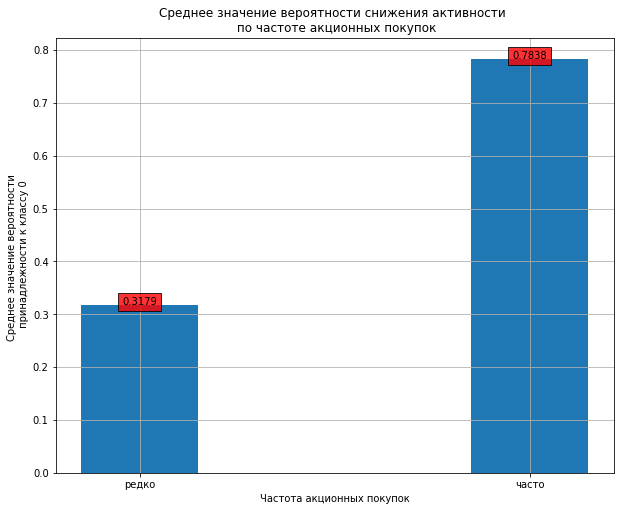

In [118]:
pivot = joined.pivot_table(index ='акционные_покупки', values = 'снизилась_активность_вероятность', aggfunc = 'mean')
pivot['снизилась_активность_вероятность'] = pivot['снизилась_активность_вероятность'].round(4)
def addlabels (x,y):
    for i in range(len(x)):
        plt.text(x = i, y = y[i], s = y[i], ha='center', bbox = dict(facecolor = 'red', alpha =.8))

plt.figure(figsize = (10,8))
plt.title(f'Среднее значение вероятности снижения активности \n по частоте акционных покупок')
plt.xlabel('Частота акционных покупок')
plt.ylabel('Среднее значение вероятности \n принадлежности к классу 0')
plt.bar(x = pivot.index, height = pivot['снизилась_активность_вероятность'], width = 0.3)
plt.grid()
addlabels(pivot.index, pivot['снизилась_активность_вероятность'])

**Так и есть, те клиенты которые часто покупают товары по акции в среднем гораздо более склонны к снижению покупательской активности. Теперь оценим распределение вероятности снижения покупателькой активности только среди тех, кто часто покупает по акции. Также разделим любителей акционных покупок на тех, кто вероятнее всего снизит активность (вероятность >= 0.8) и остальных**

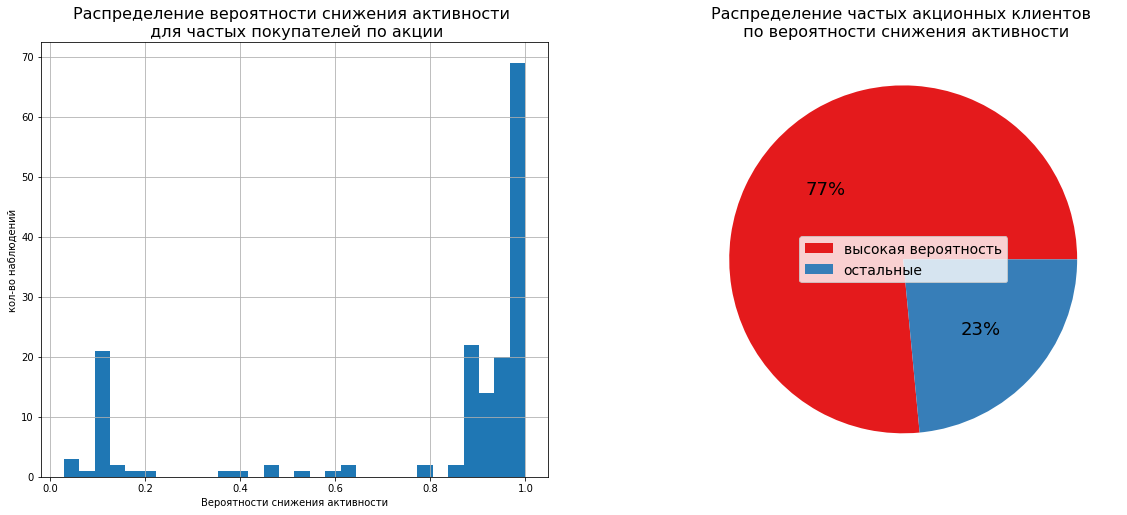

In [119]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))

df1 = joined.query('акционные_покупки == "часто"')['снизилась_активность_вероятность']
ax[0].hist(df1, bins = 30)
ax[0].set_title('Распределение вероятности снижения активности \n для частых покупателей по акции', fontdict = {'fontsize' : 16})
ax[0].set_xlabel('Вероятности снижения активности')
ax[0].set_ylabel('кол-во наблюдений')
ax[0].grid()

#отделяем тех у кого веротяность больше либо равна 0.8
df2 = df1.apply(lambda x: 'высокая вероятность' if x>= 0.8 else 'остальные')
ax[1].pie(df2.value_counts(), autopct = '%1.0f%%', colors=sns.color_palette('Set1'),textprops={'fontsize': 18})
ax[1].set_title('Распределение частых акционных клиентов \n по вероятности снижения активности', fontdict = {'fontsize' : 16})
ax[1].legend(labels = df2.value_counts().index, fontsize =14, loc = 'center')
plt.show()

**Среди клиентов, часто покупающих по акции, 77% имеют вероятность снижения покупательской активности более 0.8. На гистограмме видно, что эти клиенты делятся на две группы. Одна группа имеет низкую вероятность, другая - высокую. И вторая группа существенно преобладает. Таким образом действительно можно утверждать что любители акционных покупок - проблемная группа клиентов, склонная снижать свою активность**

Посмотрим на категориальные признаки для клиентов с частыми акционными покупками

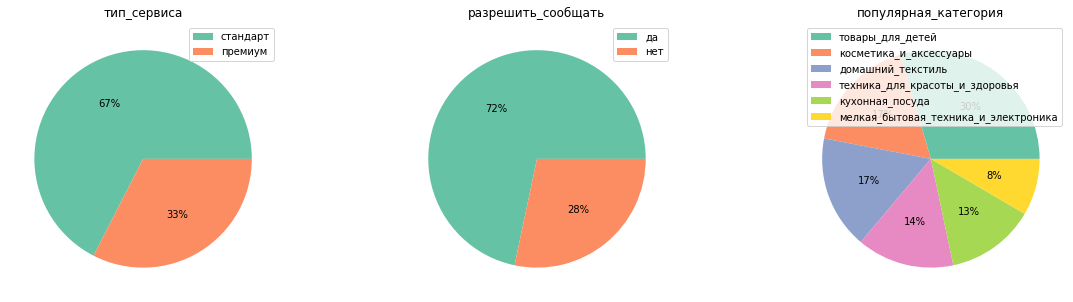

In [120]:
plot_pie(joined.query('акционные_покупки == "часто"').drop('акционные_покупки', axis = 1), lst = [])

**Любители акций чаще имеют тип сервиса - стандарт и разрешают сообщать им о дополнительных предложениях по товару. Это значит, что такие клиенты чаще всего не готовы тратить лишние деньги на подписку. Стремление сэкономить также проявляется в повышенном интересе к дополнительным предложениям. Заказчику следует уделить внимание целевой рекламе акционных товаров для клиентов, которые часто покупают по акции. Особенно почитаемыми в этом сегменте категориями являются товары для детей и косметика и аксессуары, а также домашний текстиль. В этих сегментах целевая реклама будет целесообразнее всего**

Если посмотреть на те же самые круговые диаграммы, только исключительно для тех частых покупателей, вероятность снижения активности которых выше либо равна 0.8, то картина не сильно изменится

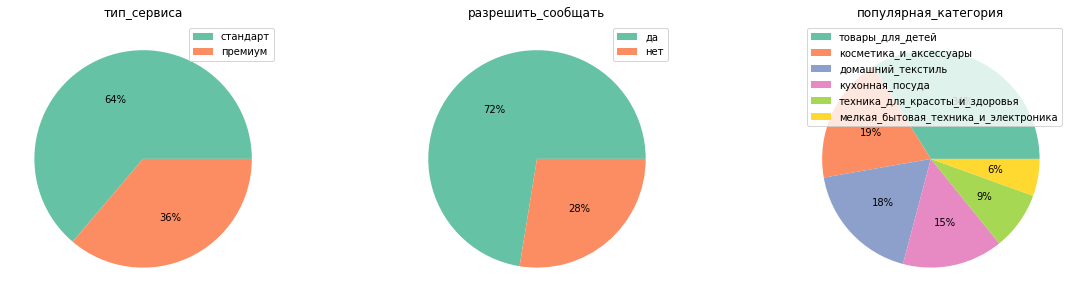

In [121]:
(plot_pie(joined.query('акционные_покупки == "часто" and снизилась_активность_вероятность >= 0.8')
          .drop('акционные_покупки', axis = 1), lst = []))

Немного подросли категории товары для детей и косметика и аксессуары. В остальном все то же самое

**Сосредоточимся на частых клиентах акций с высокой вероятностью снижения покупательской активности. Выделим эту целевую группу в датасете joined**

In [122]:
joined['группа'] = joined.apply(lambda x: 'целевая' \
             if x['снизилась_активность_вероятность'] >= 0.8 \
             and x['акционные_покупки'] == "часто" else 'нецелевая', axis = 1)

In [123]:
joined

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_тек,минут_пред,выручка_препред,выручка_тек,выручка_пред,снизилась_активность_вероятность,прибыль,группа
id,,,,,,,,,,,,,,,,,,,
215761,стандарт,нет,5.7,4,565,редко,домашний_текстиль,5,1,4,12,18.0,12.0,5023.0,3713.8,4252.0,0.078938,2.60,нецелевая
216625,стандарт,да,3.4,5,351,редко,кухонная_посуда,5,1,6,8,13.0,15.0,4949.0,5000.0,4337.0,0.051308,4.12,нецелевая
215375,премиум,да,3.0,4,558,часто,товары_для_детей,3,3,7,4,9.0,8.0,4715.0,5633.1,5253.5,0.997694,4.18,целевая
215390,стандарт,да,3.1,4,152,редко,косметика_и_аксесcуары,6,4,2,5,12.0,8.0,4549.0,4612.8,4254.0,0.897239,5.70,нецелевая
215985,стандарт,да,5.5,5,541,редко,мелкая_бытовая_техника_и_электроника,4,1,6,5,11.0,12.0,5223.0,5661.0,5388.0,0.102718,6.78,нецелевая
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215989,стандарт,да,4.7,4,529,редко,мелкая_бытовая_техника_и_электроника,4,1,0,11,20.0,20.0,4982.0,7310.0,6159.5,0.067034,3.71,нецелевая
215553,стандарт,да,0.9,4,360,редко,домашний_текстиль,2,3,3,5,10.0,6.0,4309.0,4594.3,4138.0,0.968636,3.01,нецелевая
215451,стандарт,да,3.9,3,1048,редко,товары_для_детей,4,5,4,5,14.0,11.0,4658.0,4260.1,4043.0,0.923421,5.31,нецелевая


Рассмотрим распределение прибыли для целевой и нецеловой групп

ЧИСЛОВЫЕ ХАРАКТЕРИСТИКИ ДЛЯ ГРУППЫ нецелевая
count    1169.000000
mean        4.014098
std         1.015475
min         0.860000
25%         3.300000
50%         4.060000
75%         4.710000
max         7.430000
Name: прибыль, dtype: float64

--------------------------------------------------
ЧИСЛОВЫЕ ХАРАКТЕРИСТИКИ ДЛЯ ГРУППЫ целевая
count    127.000000
mean       3.846772
std        0.961680
min        1.330000
25%        3.175000
50%        4.010000
75%        4.420000
max        6.730000
Name: прибыль, dtype: float64

--------------------------------------------------


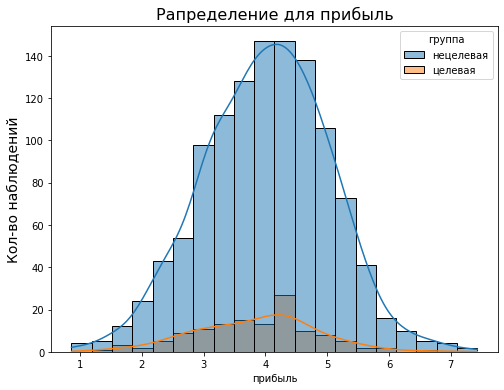

In [124]:

    
for i in ['нецелевая', 'целевая']:
    print(f'ЧИСЛОВЫЕ ХАРАКТЕРИСТИКИ ДЛЯ ГРУППЫ {i}')
    print(joined.query('группа == @i')['прибыль'].describe())
    print()
    print('-'*50)
plot_hist(joined, 'прибыль', 'группа')

В целом целевая группа такая же прибыльная как остальные нецелевые клиенты. Распределения не смещены относительно друг друга. Значит за нашу выделенную целевую группу стоит бороться. В процентном соотношении целеваая группа составляет примерно 10% всех клиентов.

**Рассмотрим все остальные числовые столбцы**

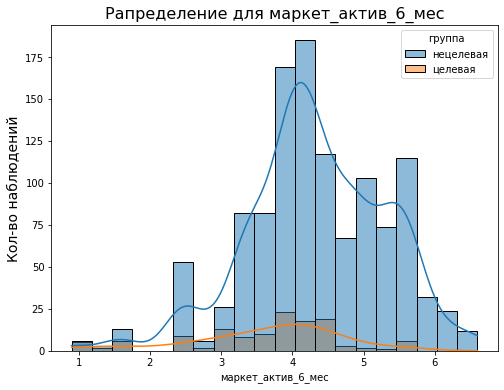

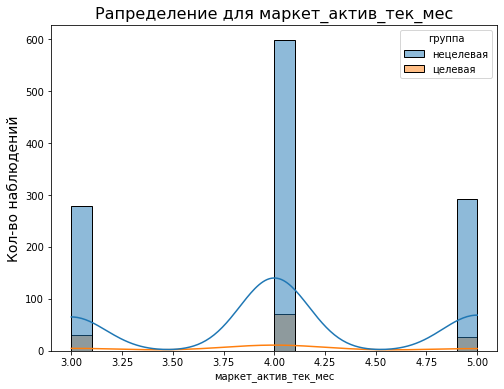

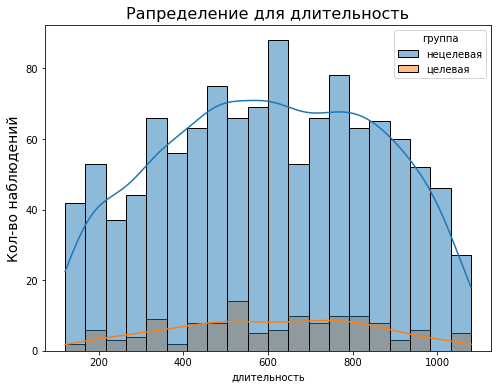

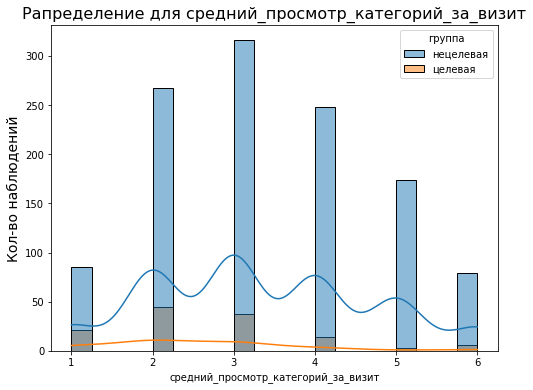

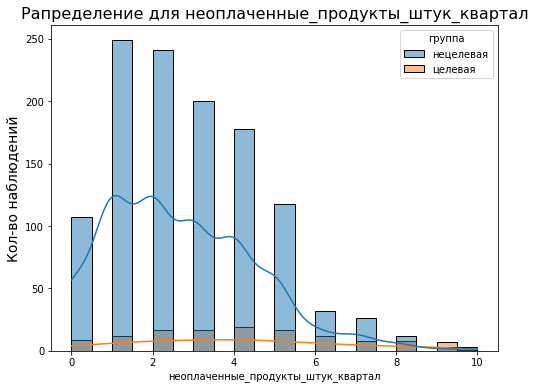

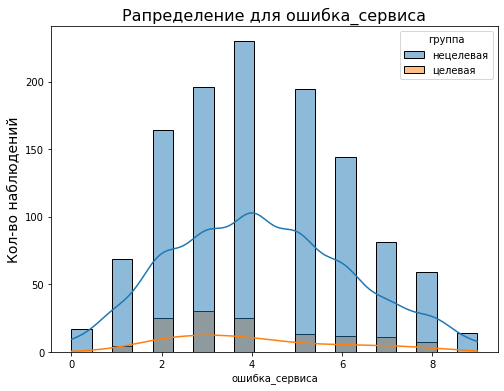

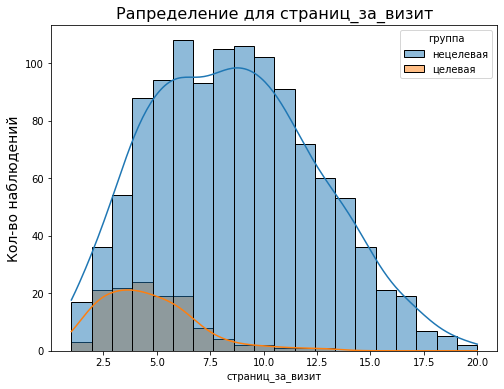

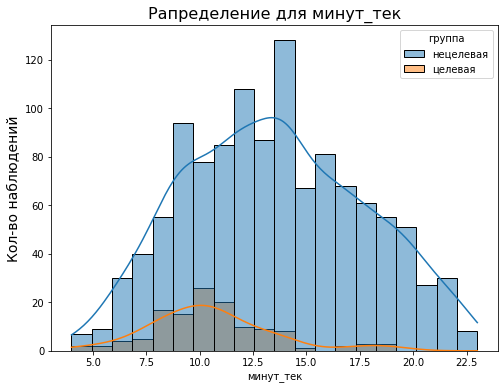

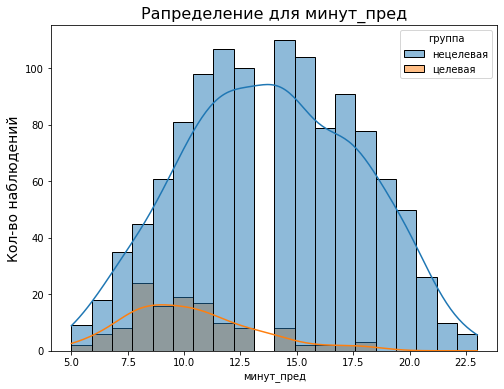

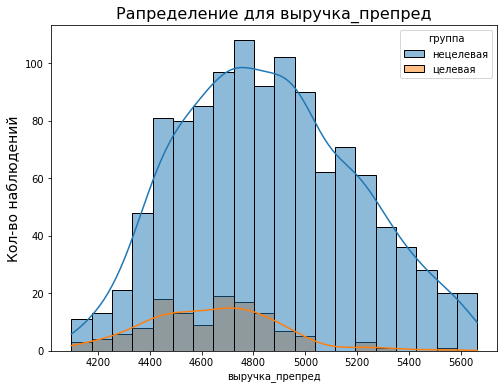

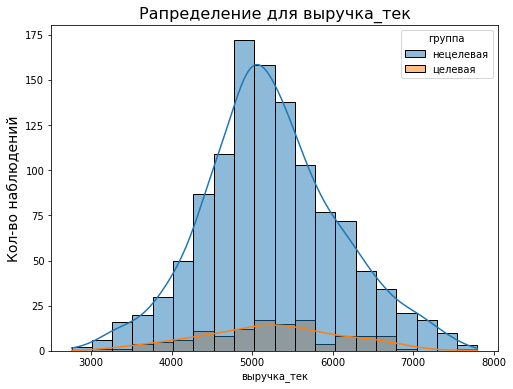

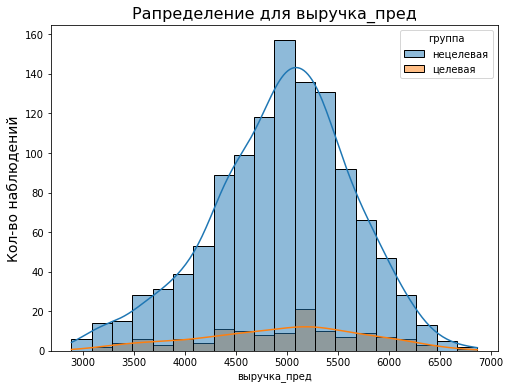

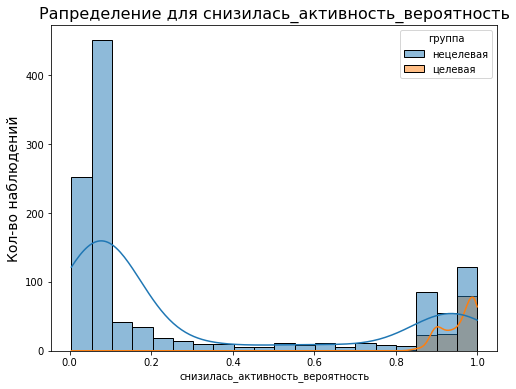

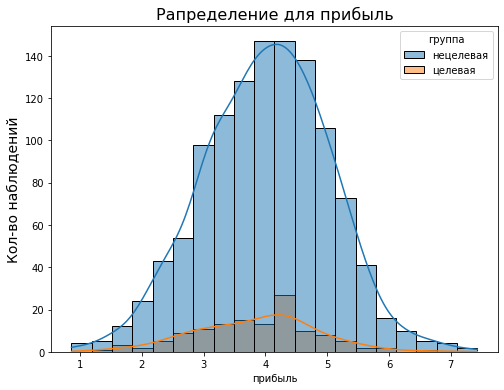

In [125]:
for i in joined.select_dtypes(include = 'number'):
    plot_hist(joined, i, 'группа')

**Для целевой группы характерны более низкие значения `минут_пред`, `минут_тек` `страниц_за_визит`. Вспомним, что эти признаки входили в тройку лидеров по важности. Низкие значения тройки лидеров склоняли модель к присвоению класса - покупательская активность снизилась. Вероятно поэтому среди любителей акционных покупок так много клиентов с высокой выроятностью этого класса**

**Вывод по разделу `Сегментация покупателей`**

В качестве целевой группы для исследования были выбраны клиенты, часто покупающие товары по акции и имеющие высокую вероятность снижения покупательской активности

- Клиенты которые часто покупают товары по акции в среднем гораздо более склонны к снижению покупательской активности.
- Среди клиентов, часто покупающих по акции, 77% имеют вероятность снижения покупательской активности более 0.8.
- Любители акций чаще имеют тип сервиса - стандарт и разрешают сообщать им о дополнительных предложениях по товару. Это значит, что такие клиенты чаще всего не готовы тратить лишние деньги на подписку. Стремление сэкономить также проявляется в повышенном интересе к дополнительным предложениям. Заказчику следует уделить внимание целевой рекламе акционных товаров для таких клиентов, которые часто покупают по акции. Особенно почитаемыми в этом сегменте категориями являются товары для детей и косметика и аксессуары, а также домашний текстиль. В этих сегментах целевая реклама будет целесообразнее всего
- Клиенты рассмотренной целевой группы тратят меньше времени на сайте и просматривают меньше страниц. Чтобы не потерять этих клиентов следует повысить их вовлеченность обилием интересных акционных предложений прямо на сайте. Отличным решением будет персонализировать такие предложения в соотвествии с популярной у данного клиента каатегорией товаров

## Общий вывод


**Вывод по разделу `Предобработка`**
- названия колонок всех трех датасетов были приведены к змеиному регистру
- пропусков и явных дупликатов в таблицах нет, типы данных столбцов соответствуют содержанию
- в `market_file был` устранен неявный дупликат `стандартт` - `стандарт`
- в `market_file` по столбцу `популярная_категория` была исправлена ошибка `аксесуары` - `аксесcуары`
- все строковые значения в `market_file` привел к змеионому регистру
- странно значение ноль среди уникальных значений столбца `выручка` датасета `market_money`. В исследовательском анализе нужно будет рассмотреть
- в `market_time` устранил опечатку `предыдцщий_месяц` -  `предыдущий_месяц`
- в `money` из-за запятой тип данных столбца `прибыль` считался как строка. Приведел к числу с плавающей точкой float

**Вывод по разделу `Исследовательский анализ`**



- <ins>`market_file`</ins>
    - Некторые распредления имеют форму нормального или напоминают его. Например `ошибка_сервиса` и `страниц_за_визит` или `средний просмотр категорий за визит`. 
    - Акционные покупки разделяются на 2 группы. Тех, у кого среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев не превосходила 0.5, и тех, кого эта доля была выше 0.8. 
    - `длительность` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, имеет самое равномерное распределение из всех, но тем не менее у графика есть эксремум
    - Нашлось 36 выбросов за пределами усов диаграммы размаха по столбцу `маркет_актив_6_мес`. Но эти выбросы нерассеяны, а распределедяются между 4 значениями. Ввиду этого выбросы удалены не были
     - В датасете наблюдается дисбаланс классов. Нужно будет это учесть при построении моделей
     - клиенты, активность которых снизилась в основном стали меньше просматривать страниц сайта и категорий товара.Также заметно, что среди снизивших активность клиентов гораздо больше тех, кто много товаров покупает по акции. Возможна группа любителей акционных покупок склонна снижать свою покупательскую активность. Высокое число неоплаченных продуктов может сигнализировать о снижении покупательской активности
     
    
    
    

- <ins>`market_money`</ins>
    - Прошлые два месяца клиент `215380` тратил по 5, 6 тыс, а в текущем потратил около 106тыс. Довольно стремительный скачок. Это аномалия. Лучше удалить клиента с этим id
    - трое клиентов с  id [215348,215357,215359] ничего не покупали в двух прошлых месяцах, но принесли выручку в текущем месяце. Ввиду их малого количества, все четверо, включая аномального клиента `215380` были удалены везде
    
    
    
    
- <ins>`market_time`</ins>
    - Выбросов по столбцу `минут` нет. Распределение почти симметричное
    
    
    
    
- <ins>`money`</ins>
    - Есть выбросы на диаграмме размаха по столцу `прибыль`, но судя по гистограмме они не выделяются из общей структуры распределения и смотрятся в нем гармонично. Не будем удалять

**Вывод по разделу `Объединение таблиц`**
- изначально в `market_money` были найдены три клиента, которые покупали только в текущем месяце, и один аномальный клиент выручка от которого в текущем месяце вдруг увеличилась более чем в 15 раз по сравнению с предыдущими месяцами. Теперь перед объединением талбиц эти 4 клиента были удалены из трех остальных датасетов 
- Сначала добавил в `market_file` столбцы `минут_тек` и `минут_пред`.В этих столбцах будут минуты за текущий и предыдущий периоды из `market_time`
- Потом также в `market_file` были добавлены `выручка_тек`, `выручка_пред`,	`выручка_препред` содержащие информацию из `market_money` о выручке за соответствующие периоды

**Вывод по разделу `Корреляционный анализ`**
- Самую высокую корреляцию имеет пара признаков `выручка_тек`и  `выручка_пред`. Выручка в текущем и предыдущем месяце соответсвенно. Коэффициент корреляции между этими двумя признаками `(0.879097)` практически подобрался к пограничному значению мультиколинеарности 0.9. Однако у обоих признаковн не наблюдается такой корреляции с `выручкой_препред`. Там коэффициенты `(0.149944)` и `(0.308041)`. Учитывая такую сильную корреляцию между выручкой в текущем месяце и выручкой в предыдущем месяце, а также то, что текущий месяц может быть еще не закончен, а значит на данные момент данные за него не полные, возможно лучше удалить признак `выручка_тек`. Либо попробовать обучить модель с ним и без него и посмотреть на метрики качества



- слабую связь по шкале Чеддока имеют такие признаки как :
    - страниц_за_визит, маркет_актив_6_мес (0.319872)
    - страниц_за_визит, минут_пред	(0.450760)
    - страниц_за_визит, выручка_препред (0.311675)
    - страниц_за_визит, акционные_покупки (-0.370860)
    - минут_пред, выручка_препред (0.348745)
    - минут_тек, минут_пред (0.360471)
    
    
    
    
- остальные признаки имеют очень слабую корреляцию

**Вывод по разделу `Использование пайплайнов`**
- **В пайплайне были перебраны методом случайного перебора 4 модели машинного обучения. Логистическая регрессия, метод опорных векторов, дерево решений и метод k-ближайших соседей**
    - Для дерева решений перебирались параметры максимальной глубины и кол-во учитываемых при разбиении признаков
    - Для логистической регрессии перебирались два типа регуляризации l1 и l2, а также сила модели 
    - Для k-ближайших соседей перебиралось число ближайших соседей
    - Для метода опорных векторов перебирались: ядро('rbf', 'linear', 'sigmoid', 'poly'), а также степень и сила модели



- **Лучшей моделью на кроссвалидации, показавшей метрику `ROC_AUC ~0.9144`, стала SVM с параметрами:**
    - ядро радиальной базисной функции
    - сила модели 4



- **Остановимся на лучшей модели `SVM ядро радиальной базисной функции, сила модели 4`, показавшей среднее значение метрики `ROC_AUC 0.914357` при кроссвалидации и `ROC_AUC 0.9034` на тестовых данных**

**Вывод по разделу `Анализ важности признаков`**

- Малозначимыми для модели можно считать признаки: 
    - `популярная категория товары для детей, кухонная посуда и бытовая техника и электроника`
    - `разрешить_сообщать`
    - `тип сервиса`
    - `маркет актив тек мес`

- Средним уровнем значимости обладаютпризнаки:
    - `популярная категория косметика и аксессуары, техника для красоты и здоровья`
    - `выручка тек`
    - `длительность`
    - `ошибка сервиса`
    
    
- Наибольшей важностью (по возрастанию) обладают:
    - `выручка пред`
    - `маркет актив 6 мес`
    - `выручка препред`
    - `акционные покупки`
    - `неоплаченные продукты штук квартал`
    - `средний просмотр категорий за визит`
    - `минут тек`
    - `минут пред`
    - `страниц за визит`
    
- Тройка особенно важных признаков(по возрастанию):
    - `минут тек`
    - `минут пред`
    - `страниц за визит`
    
    
Прежде всего заказчику следует обратить внимание на тройку лидеров по важности.Более высокие значения этих признаков вероятны для тех клиентов, покупательская активность которых останется на прежнем уровне. Иными словами не стоит переживать за клиентов которые за последние три месяца в среднем  просматривали страниц больше других. То же относится клиентам, проводившим много времени на сайте в текущем и предыдущем месяцах.


**Однако низкие значения тройки лидеров уже повод обеспокоиться вероятным снижением покупательской активности**



Еще одним хорошим индикатором активности выступает признак `средний просмотр категорий за визит`. Низкие значения этого признака сигнализируют о снижении покупательской активности. Стремиться следует к высоким значениям



Также следует обратить внимание на признаки `акционные покупки` и `неоплаченные продукты штук квартал`. Заказчику нужно стремиться к низким значениям этих показателей, чтобы как можно меньше клиентов снижали свою активность. Высокие значения этих признаков ведут к снижению покупатльской активности. Выделенная ранее группа покупателей, склонных к акционным покупкам, на shap besswarm тоже выглядит сепарированно. Это значит, что любители акционных покупок склонны снижать свою активность. Возможно причина в том, что у магазина стало мало акционных предложений. Стоит подумать о расширении персональных акций для этой группы покупателей. 

**Вывод по разделу `Сегментация покупателей`**

В качестве целевой группы для исследования были выбраны клиенты, часто покупающие товары по акции и имеющие высокую вероятность снижения покупательской активности

- Клиенты которые часто покупают товары по акции в среднем гораздо более склонны к снижению покупательской активности.
- Среди клиентов, часто покупающих по акции, 77% имеют вероятность снижения покупательской активности более 0.8.
- Любители акций чаще имеют тип сервиса - стандарт и разрешают сообщать им о дополнительных предложениях по товару. Это значит, что такие клиенты чаще всего не готовы тратить лишние деньги на подписку. Стремление сэкономить также проявляется в повышенном интересе к дополнительным предложениям. Заказчику следует уделить внимание целевой рекламе акционных товаров для таких клиентов, которые часто покупают по акции. Особенно почитаемыми в этом сегменте категориями являются товары для детей и косметика и аксессуары, а также домашний текстиль. В этих сегментах целевая реклама будет целесообразнее всего
- Клиенты рассмотренной целевой группы тратят меньше времени на сайте и просматривают меньше страниц. Чтобы не потерять этих клиентов следует повысить их вовлеченность обилием интересных акционных предложений прямо на сайте. Отличным решением будет персонализировать такие предложения в соотвествии с популярной у данного клиента каатегорией товаров


## Рекомендации

Согласно построенной модели магазину следует уделять внимание вовлеченности клиента на сайте. Наиболее важными показателями являются минуты проведенные на сайте, количество просмотренных страниц, средний просмотр категорий за визит. Стреиться нужно к повышению этих показателей. Следует также избегать роста количества неоплаченных товаров.

Особенное внимание рекомендую уделить клиентам, часто приобретающим акционные товары. Согласно проведенному исследованию они склонны к снижению покупательской активности. Это выражается в меньшем количестве времени проведенном на сайте и меньшем количестве просматриваемых страниц. Для повышения вовлеченности данных клиентов рекмендуется персонализированная реклама прямо на сайте в соотвествии с любимыми популярными категориями товара. Наиболее популярными категориями в данном сегменте являются: товары для детей и косметика и аксессуары, а также домашний текстиль. Нужно расширить количество акционных предложений для заинтересованных клиентов. В особенности для тех, кто имеют выоскую вероятность снижения покупательской активности. Также не лишним будет усовешествовать систему оповещений о новых акциях, поскольку большинство клиентов выделенного сегмента выказали желание получать информацию о дополнительных предложениях. 